# <center> Отток клиентов банка

### Цели: 
* Изучить предоставленные данные
* Подготовить данные для подачи в модель
* Построить модель для предсказания оттока клиентов банка

### Вступление:
Что такое отток клиентов банка? Это задача классификации. Нам необходимо предсказать ушедших клиентов, от тех, кто остался в банке. В имеющихся данных будем искать закономерности, чтобы банк понимал на что нужно обратить внимание, для минимизации риска ухода клиента.

### Описание признаков:
* RowNumber — номер строки
* CustomerId — уникальный номер клиента
* Surname — фамилия клиента
* CreditScore — кредитный рейтинг
* Geography — страна клиента
* Gender — пол клиента
* Age — возраст пользователя
* Tenure — количество лет, проведенных клиентом с банком
* Balance — баланс на счете пользователя
* HasCrCard — имеет ли клиент кредитную карту
* NumOfProducts — количество продуктов, которые клиент приобрел в банке
* IsActiveMember — активный клиент
* EstimatedSalary — размер зарплаты
* Exited — покинул клиент банк

#### 0.0 Импорт необходимых библиотек, загрузка данных.

In [1]:
import pandas as pd
import numpy as np
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import os 
import zipfile
from zipfile import ZipFile
import requests
import shutil
from getpass import getpass
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from scipy.stats import shapiro, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
import seaborn as sns 
import optuna
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import joblib
warnings.filterwarnings("ignore")
np.random.seed(13)

/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем наш датасет.

In [2]:
# Загружаем объект kaggle api и активируем его 
kaggle_api = KaggleApi()
kaggle_api.authenticate()

# Ссылка на наш датасет 
dataset_url = "santoshd3/bank-customers/"

# Указываем путь сохранения 
save_path = "data"

# Загружаем файл 
kaggle_api.dataset_download_files(dataset=dataset_url, path=save_path, unzip=True)

#### 1.0 Очистка данных.

In [3]:
# Для начала прочитаем данные и посмотрим на первые 5 строк 
df = pd.read_csv('data/Churn Modeling.csv')
print(df.shape)
df.head()

(10000, 14)


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
# Удалим явно лишние признаки 
df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1, inplace=True)
print(df.shape)
df.head()

(10000, 11)


CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [5]:
# Взглянем на пропуски и тип признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Пропусков нет, в данных присутвуют два категориальных признака, смотрим дальше. Выбросы очень опасны, сначала займёмся ими.

In [6]:
# Выводим статистическую информацию
df.describe(include='all')

CreditScore Geography Gender           Age        Tenure  \
count   10000.000000     10000  10000  10000.000000  10000.000000   
unique           NaN         3      2           NaN           NaN   
top              NaN    France   Male           NaN           NaN   
freq             NaN      5014   5457           NaN           NaN   
mean      650.528800       NaN    NaN     38.921800      5.012800   
std        96.653299       NaN    NaN     10.487806      2.892174   
min       350.000000       NaN    NaN     18.000000      0.000000   
25%       584.000000       NaN    NaN     32.000000      3.000000   
50%       652.000000       NaN    NaN     37.000000      5.000000   
75%       718.000000       NaN    NaN     44.000000      7.000000   
max       850.000000       NaN    NaN     92.000000     10.000000   

              Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count    10000.000000   10000.000000  10000.00000    10000.000000   
unique            NaN            NaN          NaN             NaN   
top               NaN            NaN          NaN             NaN   
freq              NaN            NaN          NaN             NaN   
mean     76485.889288       1.530200      0.70550        0.515100   
std      62397.405202       0.581654      0.45584        0.499797   
min          0.000000       1.000000      0.00000        0.000000   
25%          0.000000       1.000000      0.00000        0.000000   
50%      97198.540000       1.000000      1.00000        1.000000   
75%     127644.240000       2.000000      1.00000        1.000000   
max     250898.090000       4.000000      1.00000        1.000000   

        EstimatedSalary        Exited  
count      10000.000000  10000.000000  
unique              NaN           NaN  
top                 NaN           NaN  
freq                NaN           NaN  
mean      100090.239881      0.203700  
std        57510.492818      0.402769  
min           11.580000      0.000000  
25%        51002.110000      0.000000  
50%       100193.915000      0.000000  
75%       149388.247500      0.000000  
max       199992.480000      1.000000

Стоит обратить внимание на признаки заработной платы, баланса. Более детально разберём признак ЗП и баланса, учитывая, что у нас страны, у которых основная валюта ЕВРО, суммы получаются очень большими.

In [7]:
# Зафиксируем номинативные и количественные признаки в списки 
num_cols = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age']
nom_cols = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 
            'NumOfProducts', 'IsActiveMember']

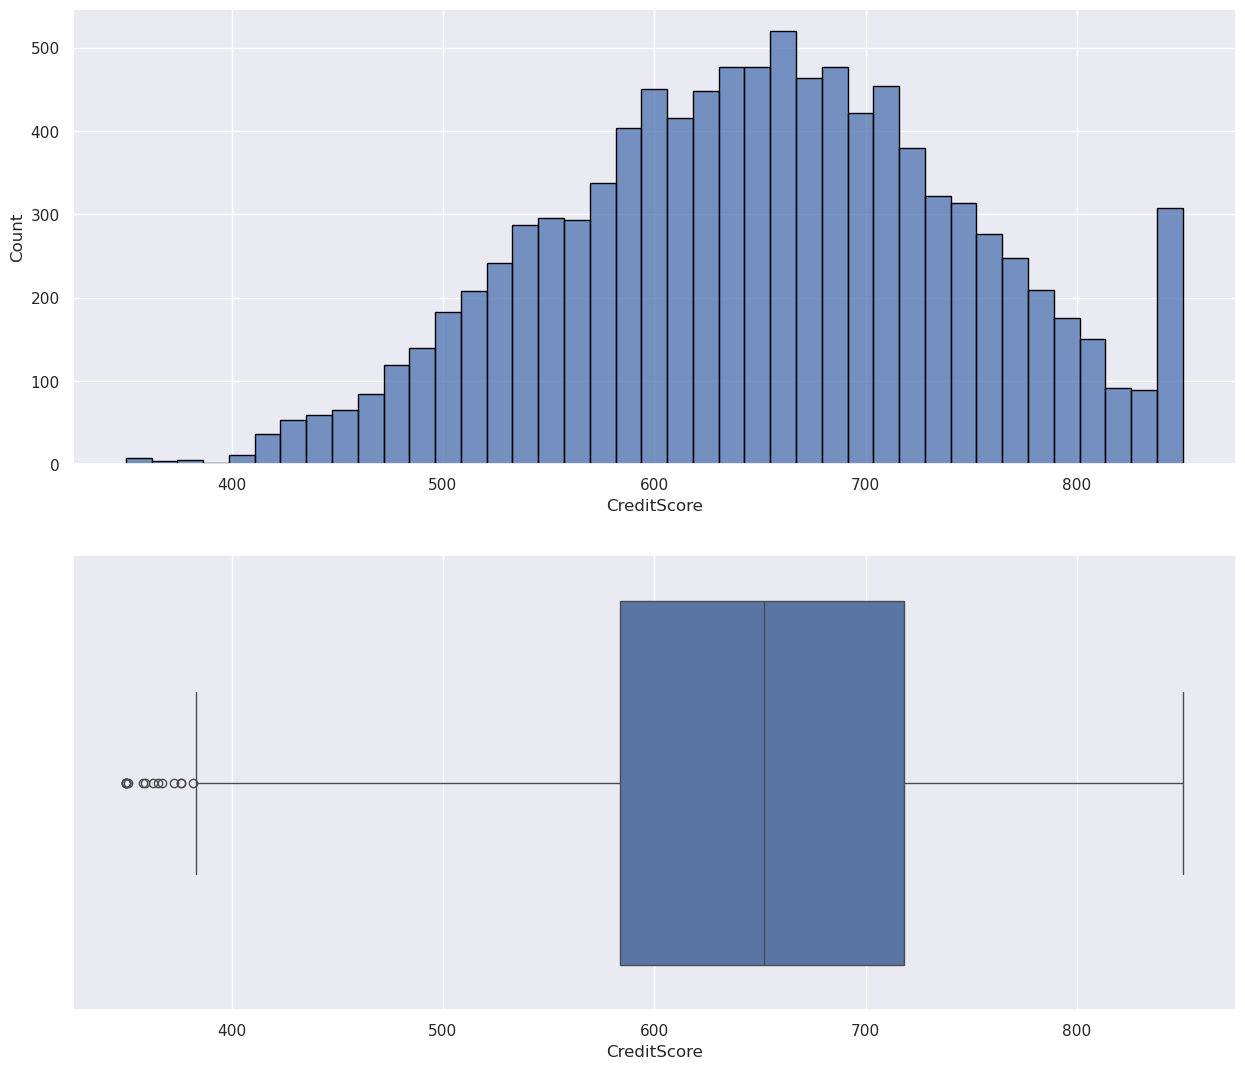

*******************************************************************************


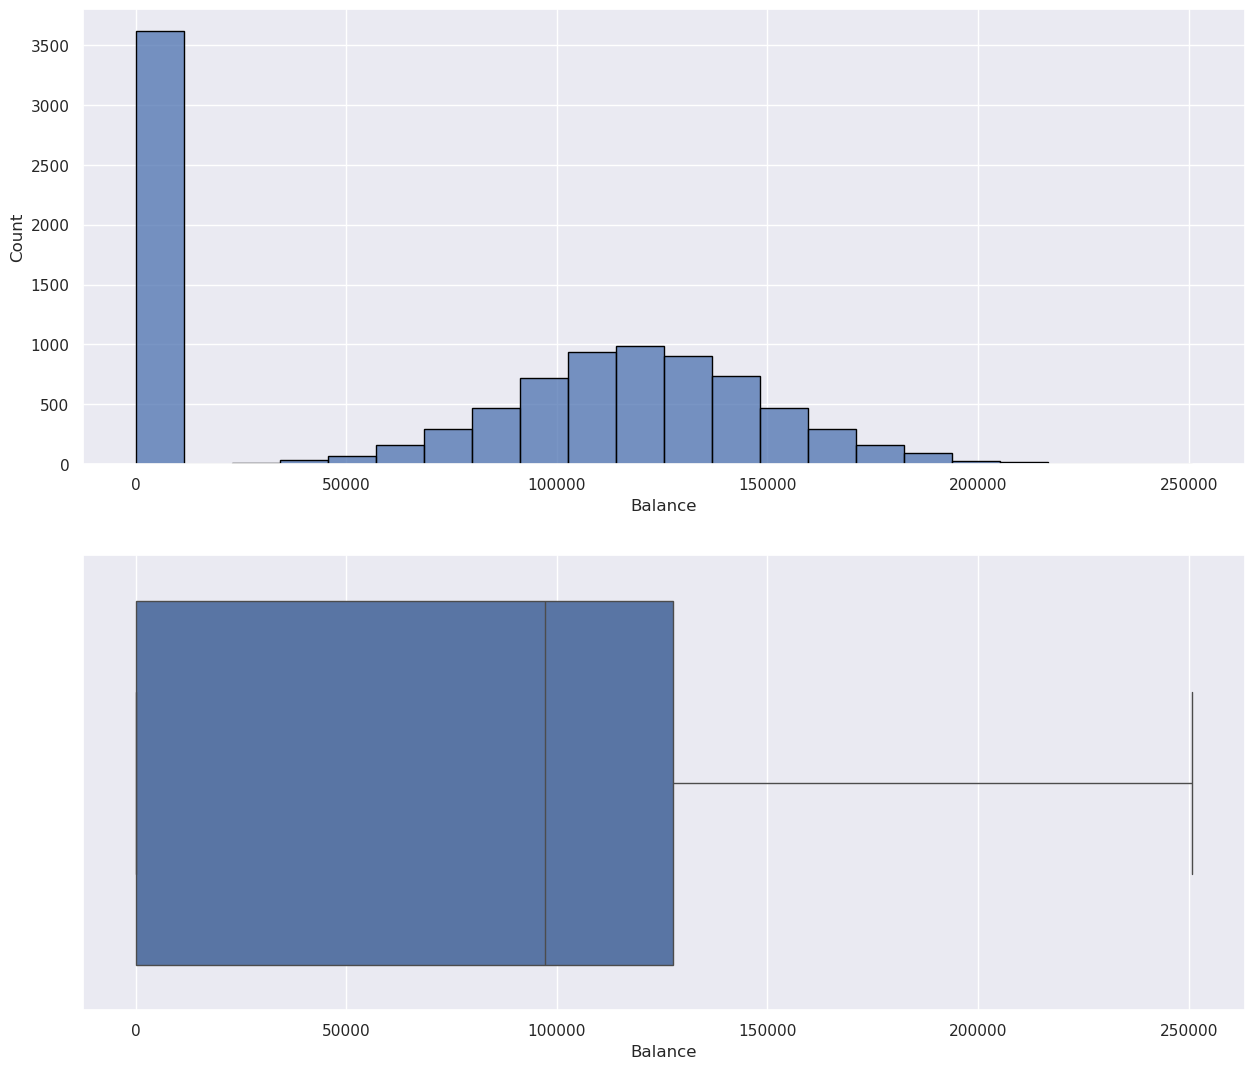

*******************************************************************************


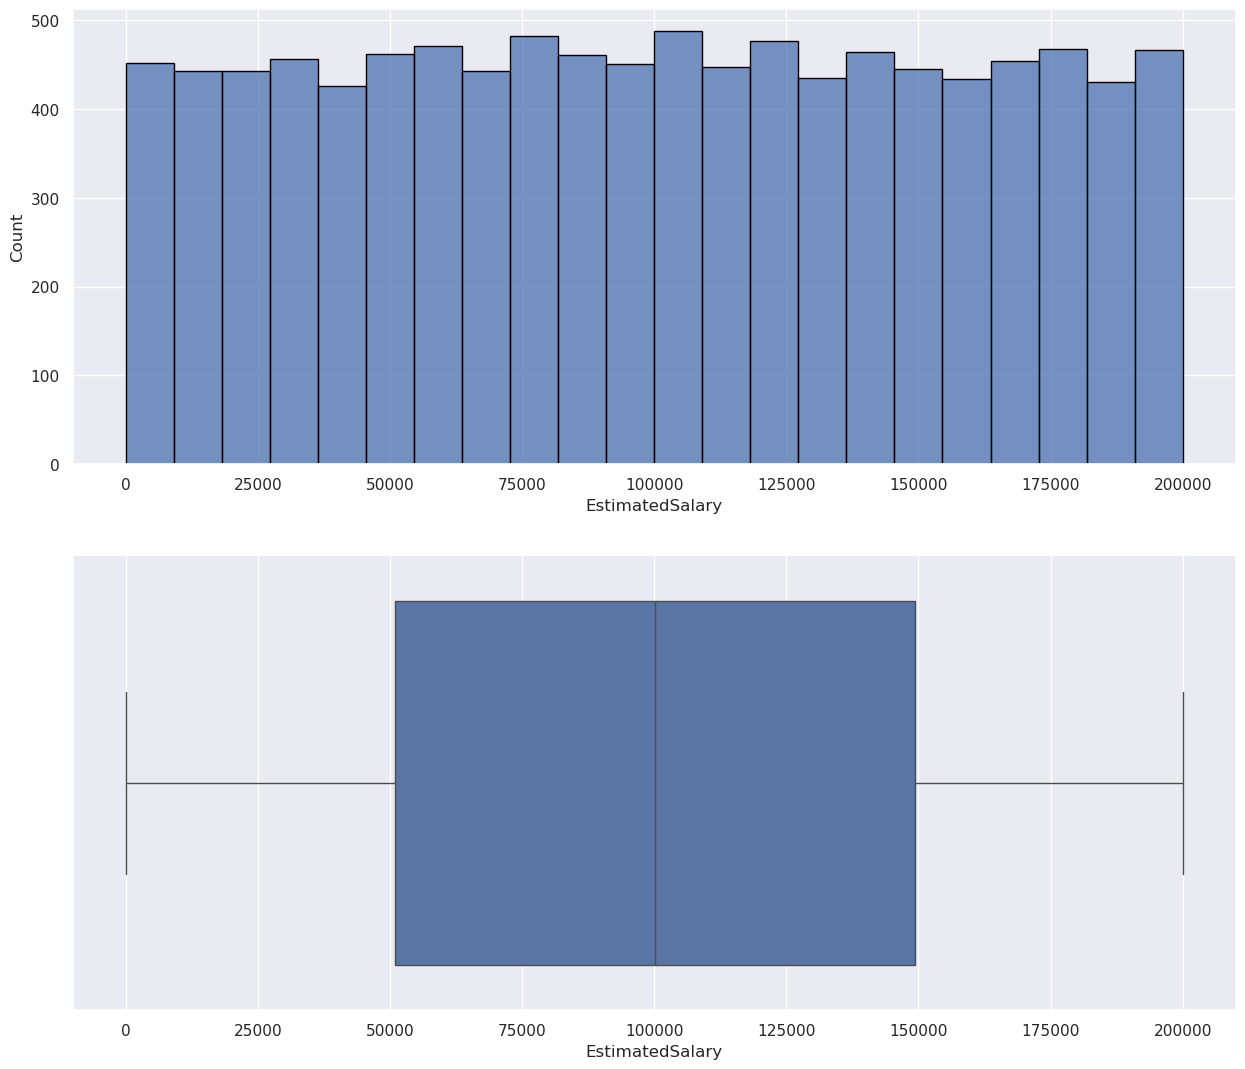

*******************************************************************************


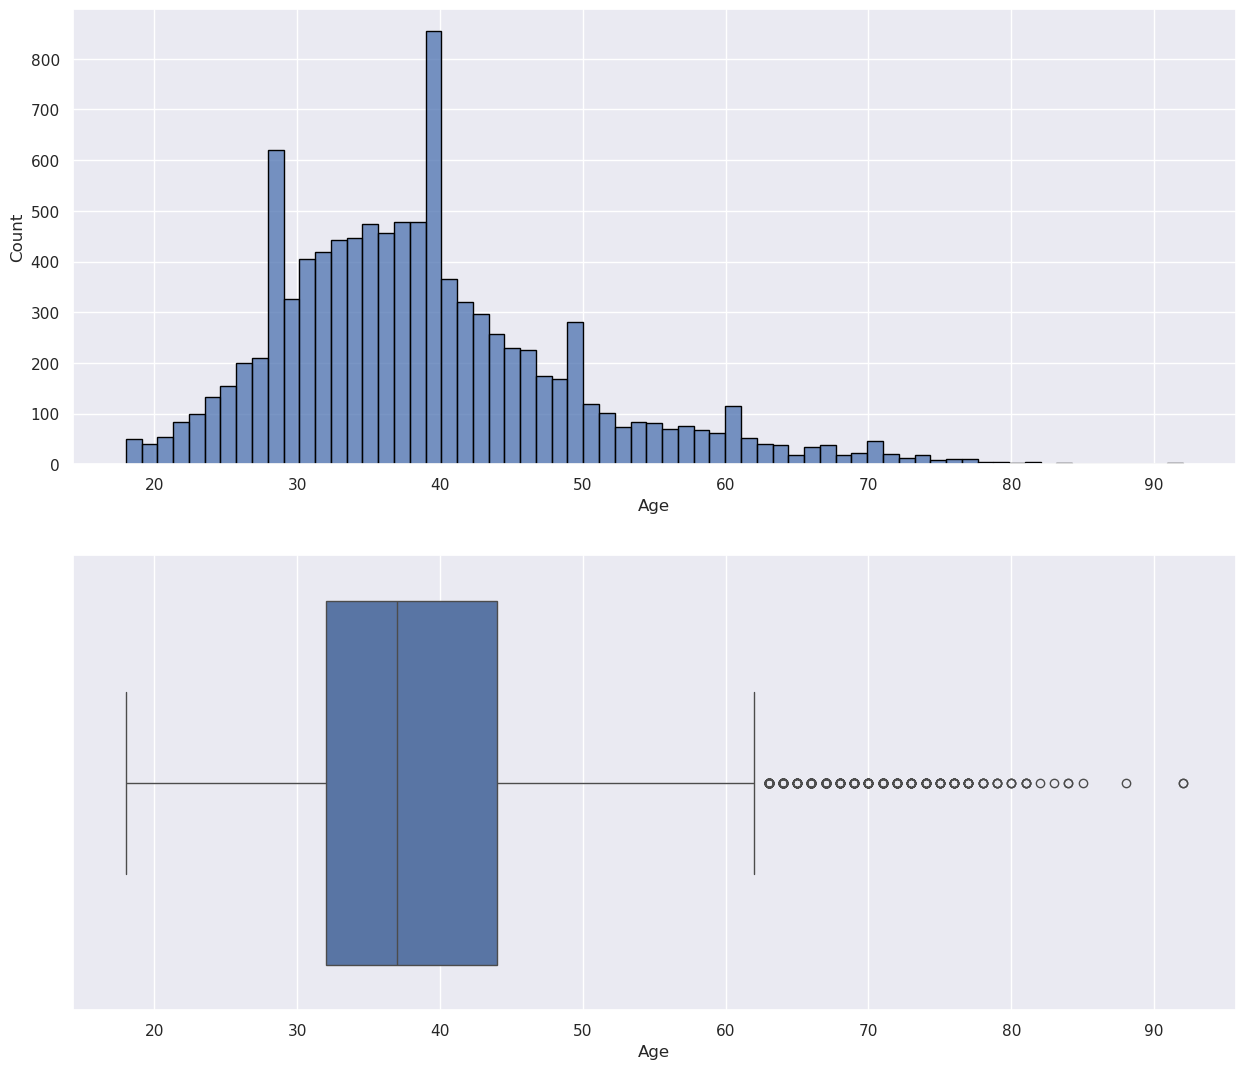

*******************************************************************************


In [8]:
# Построи графики на количественных признаках, проверим распределение 
# и возможные выбросы 
# Для лучшего отображения установим стиль графиков 
sns.set(style='darkgrid')

# С помощью цикла переберём признаки и построи графики 
for x in num_cols:
    # Строим плоскость и делим на две ячейки 
    fig, (ax1, ax2) = plt.subplots(figsize=(15,13), nrows=2, ncols=1)

    # Строим графики с указанием ячейки 
    sns.histplot(data=df, x=x, ax=ax1, linewidth=1, edgecolor='black')
    sns.boxplot(data=df, x=x, ax=ax2)
    plt.show();
    print('*' * 79)

По графикам видны выбросы, проведём тест на выбросы по методу Тьюки.

Тест по признаку CreditScore:
Число выбросов по методу Тьюки: 15
Результирующее число записей: 9985


<AxesSubplot: xlabel='CreditScore'>

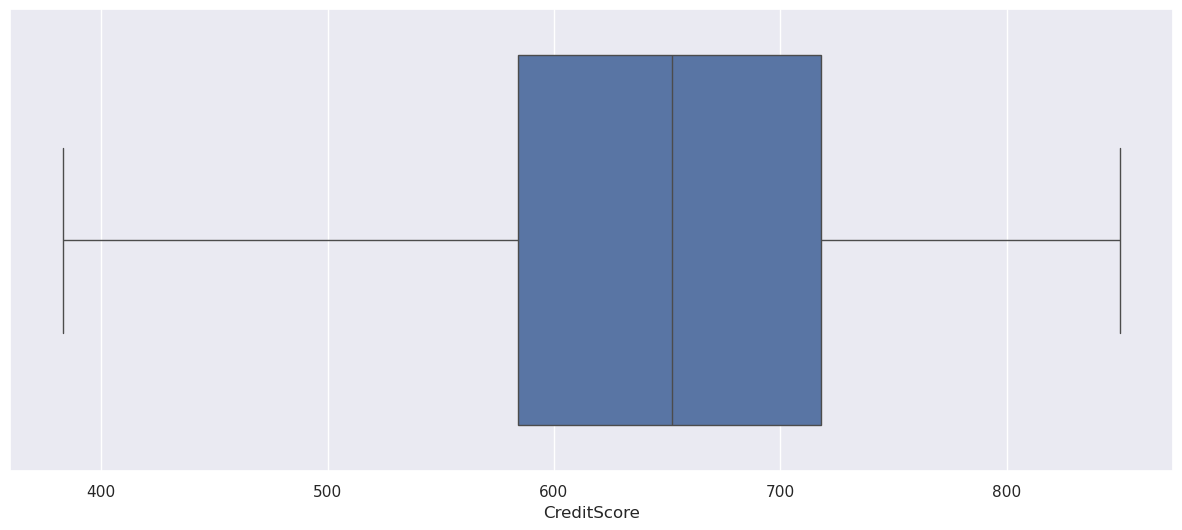

*******************************************************************************
Тест по признаку Balance:
Число выбросов по методу Тьюки: 0
Результирующее число записей: 9985


<AxesSubplot: xlabel='Balance'>

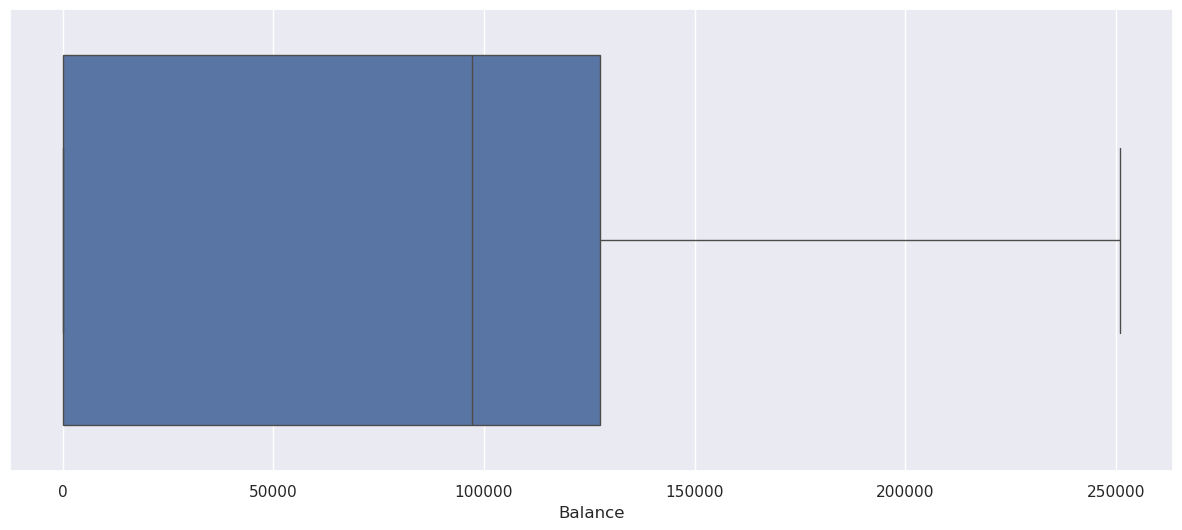

*******************************************************************************
Тест по признаку EstimatedSalary:
Число выбросов по методу Тьюки: 0
Результирующее число записей: 9985


<AxesSubplot: xlabel='EstimatedSalary'>

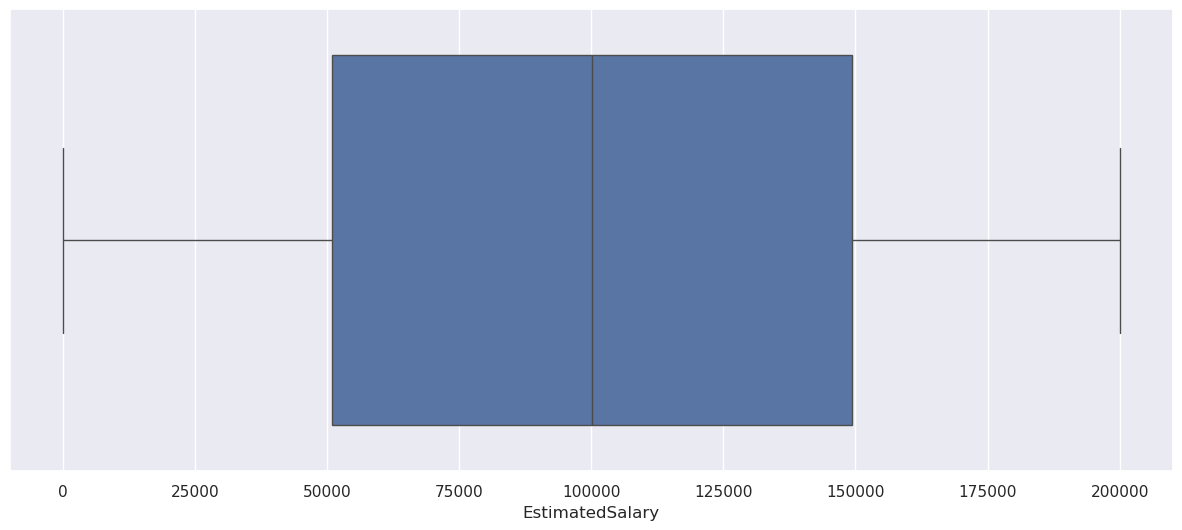

*******************************************************************************
Тест по признаку Age:
Число выбросов по методу Тьюки: 359
Результирующее число записей: 9626


<AxesSubplot: xlabel='Age'>

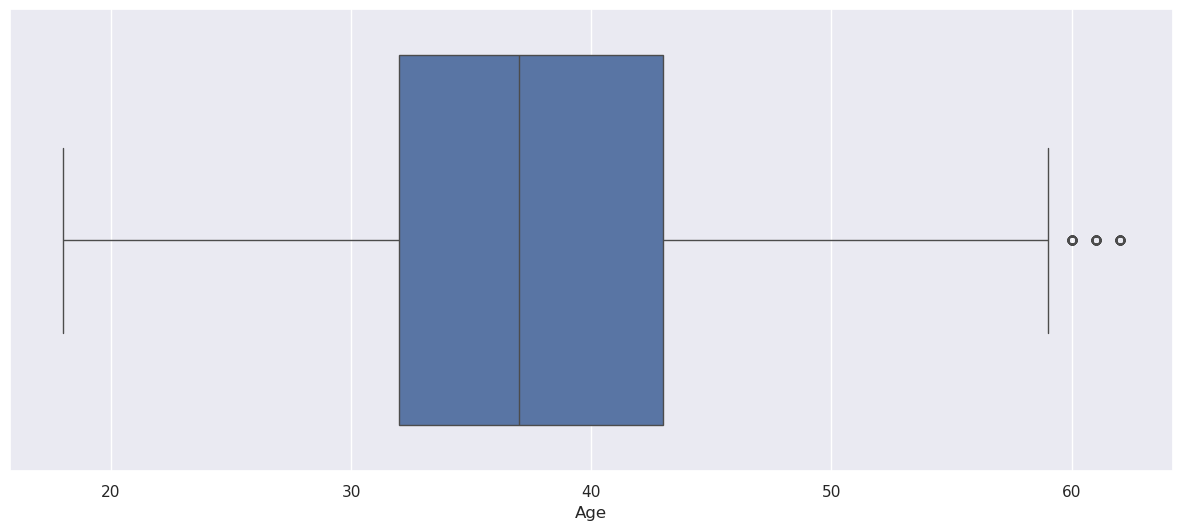

*******************************************************************************


In [9]:
# Применим метод Тьюки
# Напишем функцию 
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Создадим копию данных 
df_out_iqr = df.copy()

# Применяем её так же используя цикл 
for x in num_cols:
    print(f'Тест по признаку {x}:')
    outliers, cleaned = outliers_iqr(df_out_iqr, x)
    print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
    print(f'Результирующее число записей: {cleaned.shape[0]}')

    # Изменяем начальные данные 
    df_out_iqr = cleaned.copy()

    # Сразу же будем строить график, для проверки чистых данных
    plt.subplots(figsize=(15, 6));
    display(sns.boxplot(data=df_out_iqr, x=x));
    plt.show();
    print('*' * 79)

Дополнительно проведём проверку по методу z-отклонения.

Тест по признаку CreditScore:
Число выбросов по методу z-отклонения: 8
Результирующее число записей: 9992


<AxesSubplot: xlabel='CreditScore'>

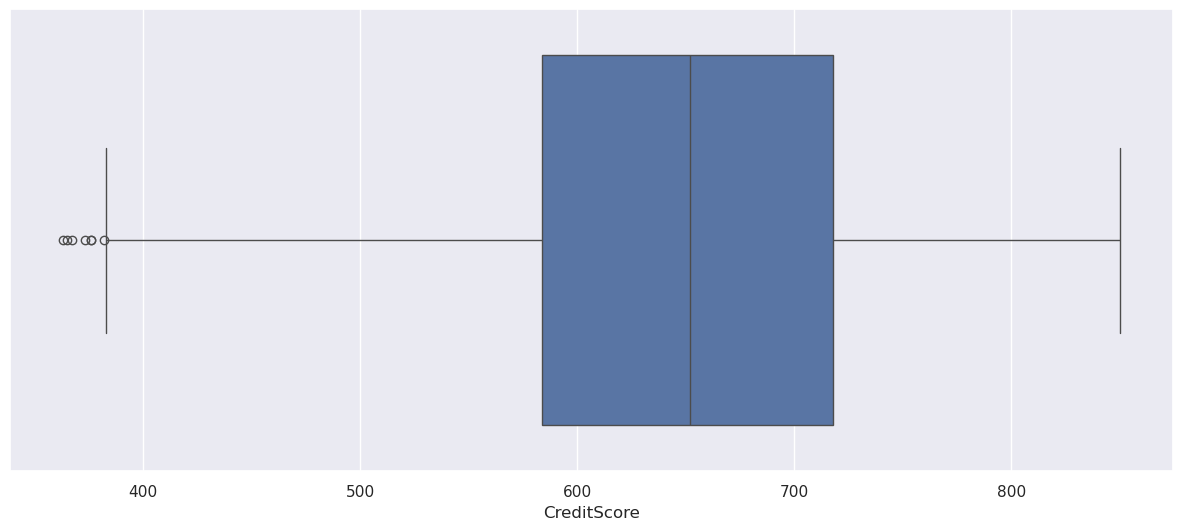

*******************************************************************************
Тест по признаку Balance:
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 9992


<AxesSubplot: xlabel='Balance'>

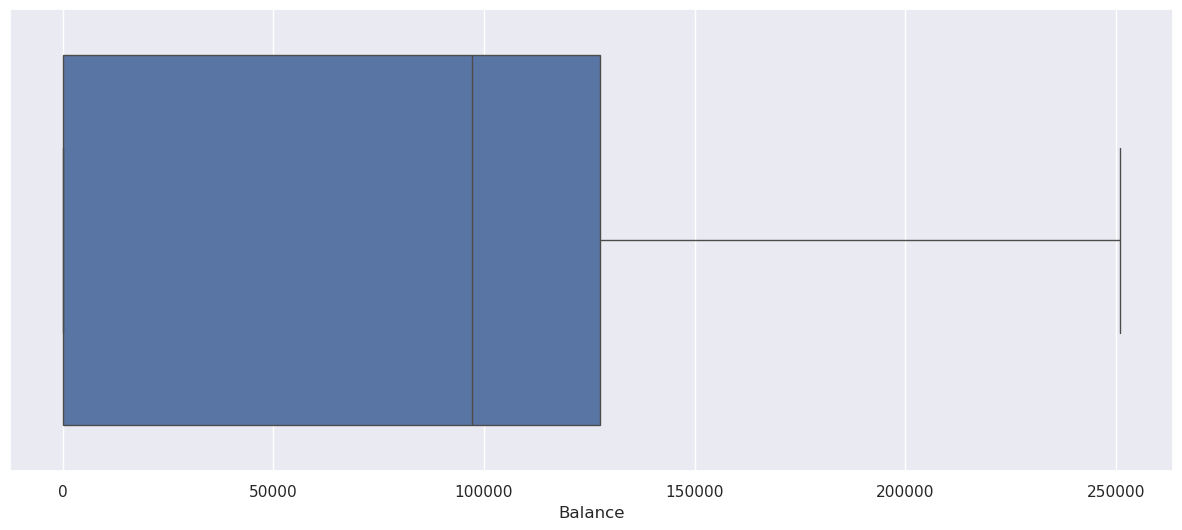

*******************************************************************************
Тест по признаку EstimatedSalary:
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 9992


<AxesSubplot: xlabel='EstimatedSalary'>

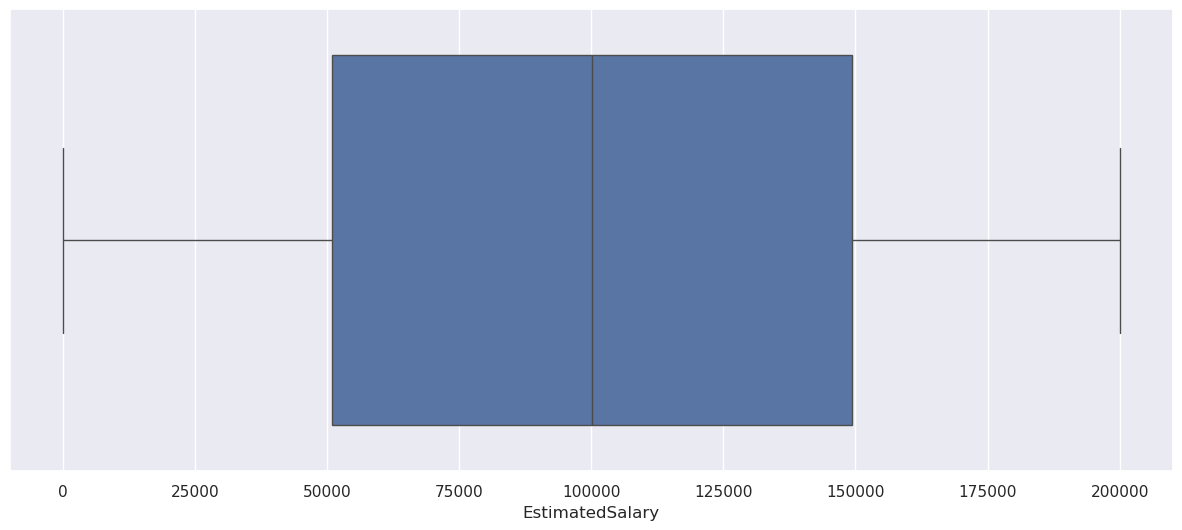

*******************************************************************************
Тест по признаку Age:
Число выбросов по методу z-отклонения: 133
Результирующее число записей: 9859


<AxesSubplot: xlabel='Age'>

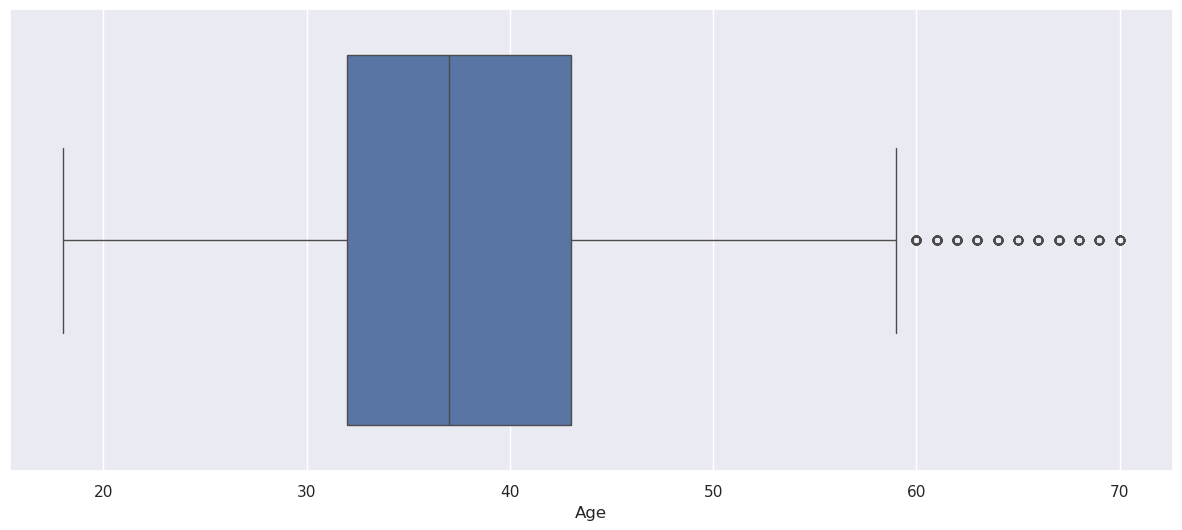

*******************************************************************************


In [10]:
# Напишем функцию z-отклонения
def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Создадим копию данных 
df_out_z = df.copy()

# Так же пройдёмся циклом, установив условие поиска признака ЗП 
for feature in num_cols:
    print(f'Тест по признаку {feature}:')
    
    # Применяем функцию
    outliers, cleaned = outliers_z_score(df_out_z, feature)
    print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    print(f'Результирующее число записей: {cleaned.shape[0]}')

    # Изменяем начальные данные 
    df_out_z = cleaned.copy()

    # И выводим графики
    plt.subplots(figsize=(15, 6));
    display(sns.boxplot(data=df_out_z, x=feature));
    plt.show();
    print('*' * 79)

Метод Тьюки лучше справился с выбросами, сохраним выборку.

In [11]:
# Для удобства зафиксируем новые переменные 
df_copy = df.copy() # Сохраним начальную версию DataFrame
df = df_out_iqr.copy()

In [12]:
# Проверим кол-во дубликатов, если такие есть, конечно удалим их
# Для начала составим список признаков
df_cols = list(df.columns)

# Напишем маску дубликатов 
mask_dupl = df.duplicated(subset=df_cols)

# Теперь в переменную зафиксируем дубли 
df_dupl = df[mask_dupl]
print(f"Кол-во дубликатов : {df_dupl.shape[0]}")

Кол-во дубликатов : 0


Отлично, в данных нет дубликатов, переходим к след. этапу разведовательный анализх данных.

#### 2.0 EDA

В разделе EDA мы будем искать зависимости, неправильные данные, попутно исправляя ошибки, возможно, даже придумаем новые признаки, которые помогут нашей модели. Посмотрим статистику по разным странам.

In [13]:
# Фиксируем выборки по странам
df_ger = df[df['Geography'] == 'Germany']
df_fr = df[df['Geography'] == 'France']
df_sp = df[df['Geography'] == 'Spain']

In [14]:
# Напишем функцию для вывода статистических показателей по признакам
def get_mean_median(data):
    print(f"Кол-во клиентов: {data.shape[0]}")
    cols_lst = list(data.columns)
    count_lst = ['NumOfProducts', 'Exited', 'HasCrCard', 'Tenure', 'IsActiveMember']
    cols_lst.remove('Geography')
    cols_lst.remove('Gender')
    for feature in cols_lst:
        if feature in count_lst:
            print(f"Кол-во клиентов по признаку {feature}")
            print(data[feature].value_counts(), '\n')
        else:
            print(f"Максимальный показатель по признаку {feature}: {round(data[feature].max(), 2)}")
            print(f"Минимальный показатель по признаку {feature}: {round(data[feature].min(), 2)}")
            print(f"Средний показатель по признаку {feature}: {round(data[feature].mean(), 2)}")
            print(f"Медианный показатель по признаку {feature}: {round(data[feature].median(), 2)}")
            print('')
    print('*' * 79, '\n')

In [15]:
# Применяем нашу функцию на выборках 
print('Тест Германии:')
get_mean_median(df_ger)

print('Тест Франции:')
get_mean_median(df_fr)

print('Тест Испании:')
get_mean_median(df_sp)

Тест Германии:
Кол-во клиентов: 2421
Максимальный показатель по признаку CreditScore: 850
Минимальный показатель по признаку CreditScore: 395
Средний показатель по признаку CreditScore: 651.9
Медианный показатель по признаку CreditScore: 651.0

Максимальный показатель по признаку Age: 62
Минимальный показатель по признаку Age: 18
Средний показатель по признаку Age: 38.74
Медианный показатель по признаку Age: 38.0

Кол-во клиентов по признаку Tenure
2     267
9     260
8     259
1     255
3     250
5     250
4     227
7     219
6     210
10    124
0     100
Name: Tenure, dtype: int64 

Максимальный показатель по признаку Balance: 214346.96
Минимальный показатель по признаку Balance: 32197.64
Средний показатель по признаку Balance: 119777.28
Медианный показатель по признаку Balance: 119714.25

Кол-во клиентов по признаку NumOfProducts
1    1299
2    1008
3      91
4      23
Name: NumOfProducts, dtype: int64 

Кол-во клиентов по признаку HasCrCard
1    1726
0     695
Name: HasCrCard, dtyp

* По признаку кредитной истории лидерство забирает Франция, минимальный уровень выше чем у Германии и Испании, хотя среднее и медианное значение не имеют большой разницы. 

* Так же самый старший клиент обслуживается в Франции, у других стран показатель немного ниже. 

* По признаку кол-во лет работы с банком значения сильно разняться, в Германии тройку лидеров занимают 2/9/1 лет, в Франции 7/1/2, в Испании 8/5/3. 

* Самый выкосий показатель баланса в Испании, при этом Германия забирает лидерство по среднему и медианному показателю, Франция и Испания находятся примерно на одном уровне. 

* Исходя из признака кол-во продуктов, Франция снова побеждает, данные сильно ушли вперёд, у Германии и Испании +- одинковые значения. 

* Признак наличия кредитной карты показывает большее кол-во в Франции, в Германии и Испании опять показатели похожи. 

* У признака активности интересные данные, в Германии больше неактивных клиентов, в Франции и Испании больше активных клиентов.

* Признак ЗП, максимальный показатель во всех странах примерно одинкаовый, минимальная заработная плата наблютается в Германии, средние и медианные значения выше в Германии, за ней идёт Франция и Испания.

* Признак ухода во всех странах преобладает лояльные клиенту. Так же стоит обратить внимание, что в Франции данных клиентов почти в 2 раза больше, чем в других.

У нас есть категориальные признаки, закодируем их.

In [16]:
encoder = OrdinalEncoder()

# Пропишем список признаков для кодирования 
encode_lst_cols = ['Geography', 'Gender']

# С помощью цикла пройдём по признакам 
for col in encode_lst_cols:
    # Для дальнейшего отображения принципа кодировщика, зафиксируем переменную
    first_col = df[col].unique().copy()
    # Применяем наш объект 
    df[col] = encoder.fit_transform(df[[col]])
    print(f"{col} - {df[col].unique()}: {first_col}")

Geography - [0. 2. 1.]: ['France' 'Spain' 'Germany']
Gender - [0. 1.]: ['Female' 'Male']


Чтобы понять какой метод корреляции использовать, проверим нормальное ли у нас распределение.

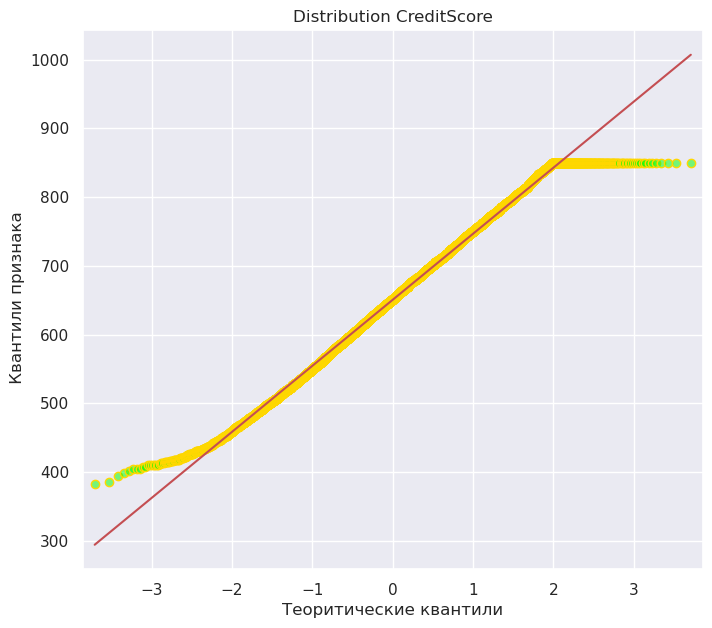

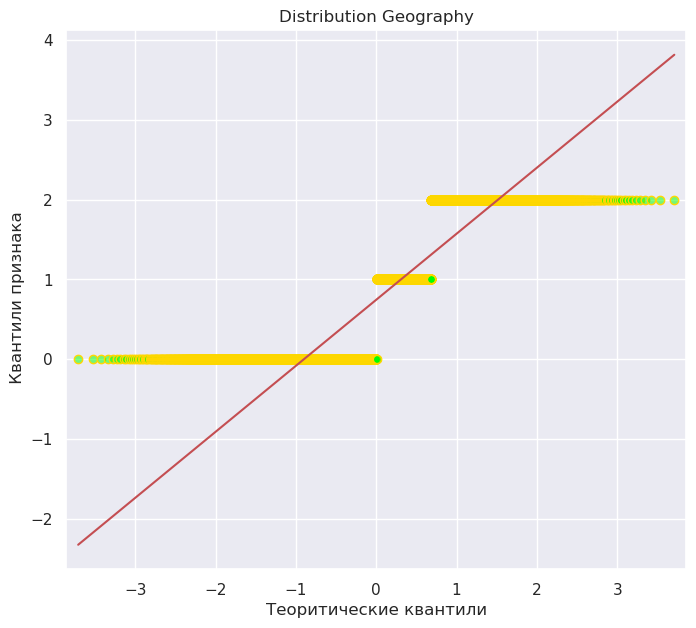

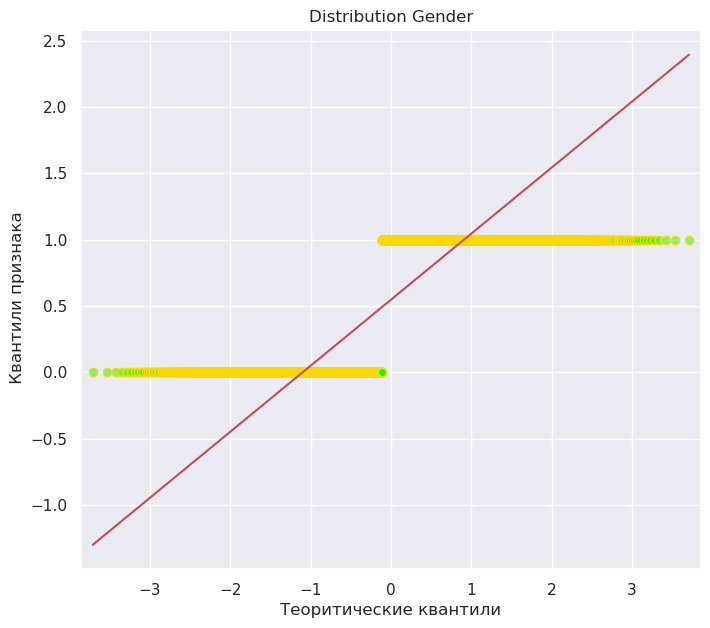

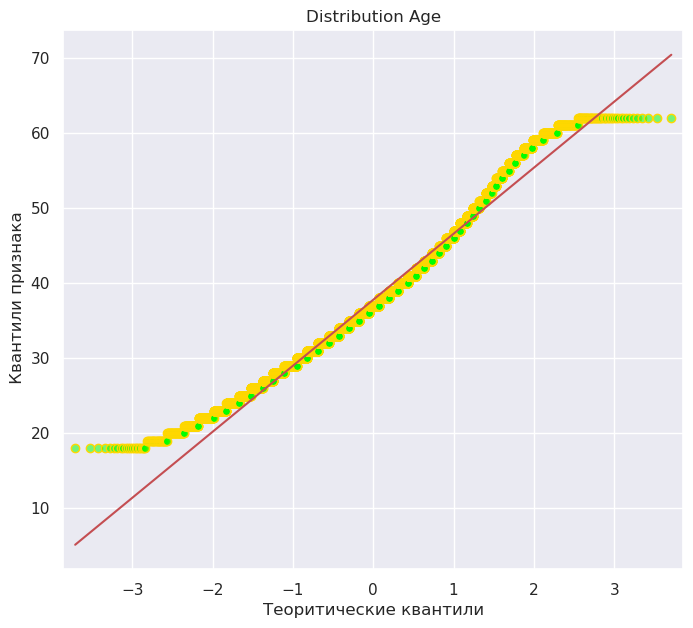

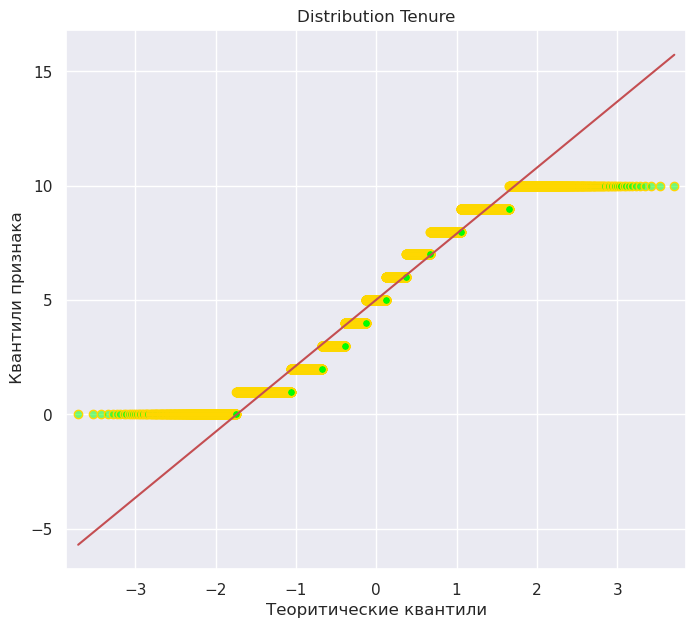

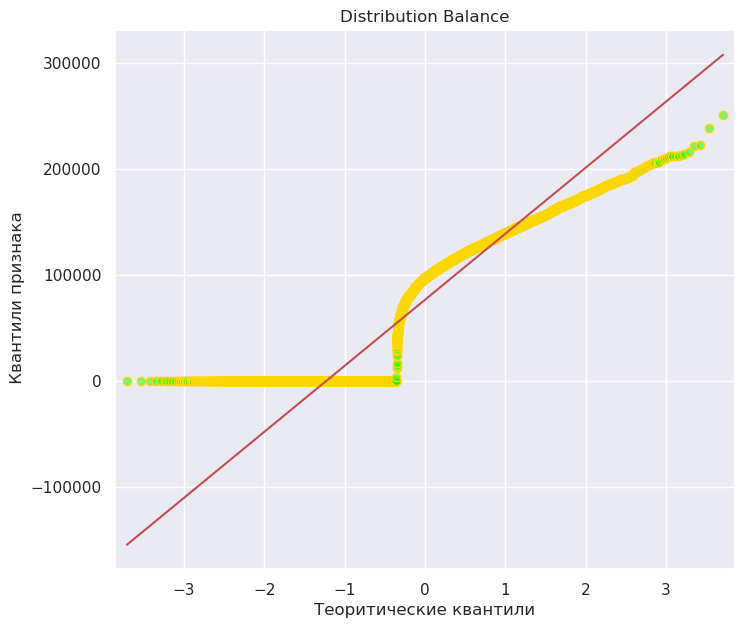

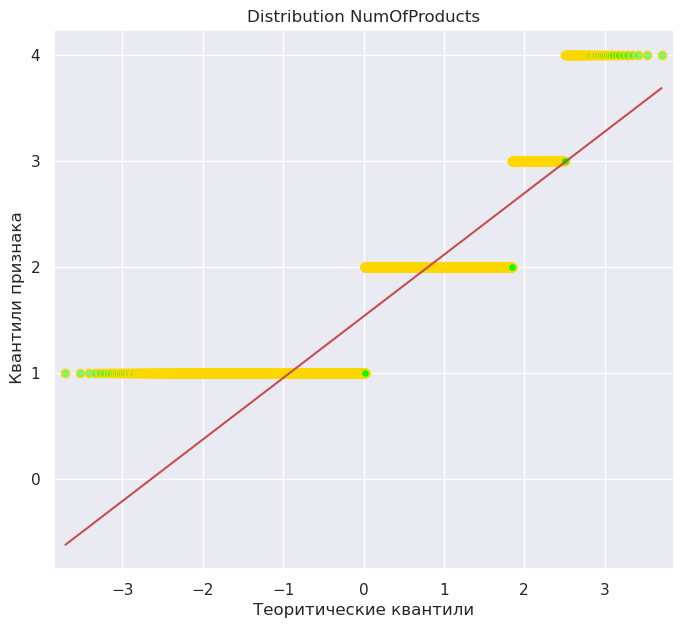

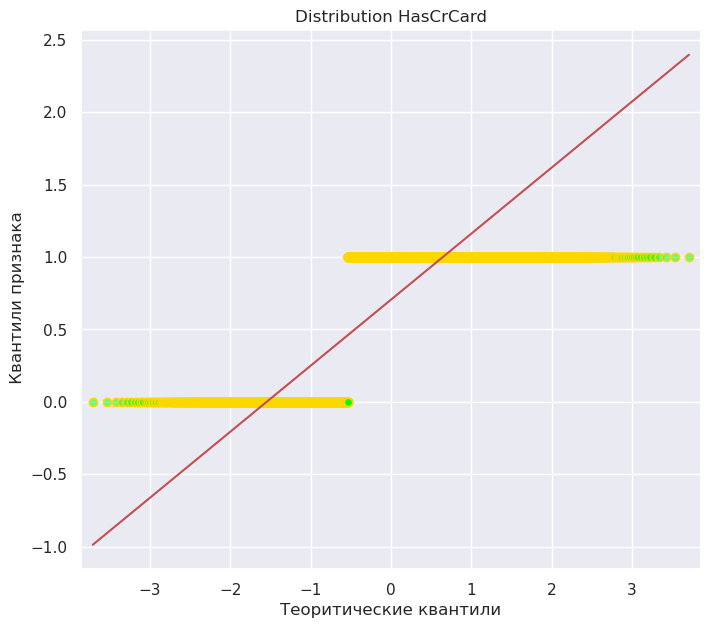

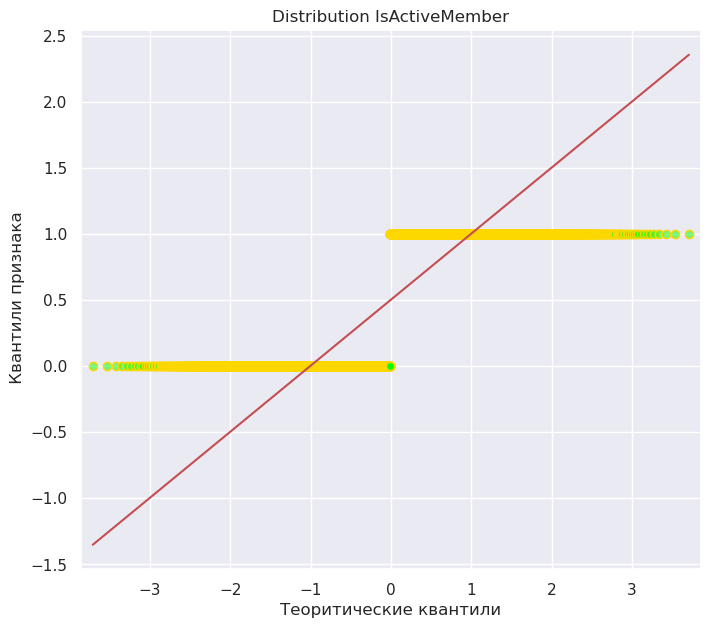

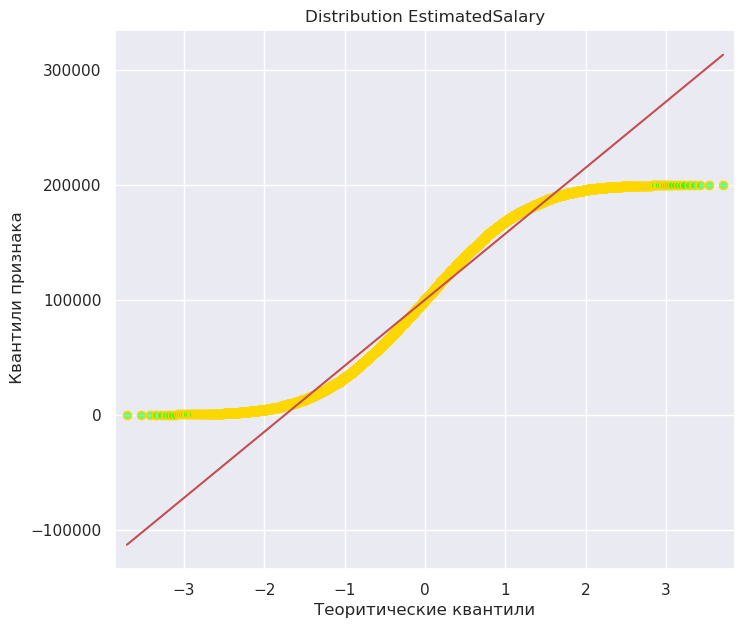

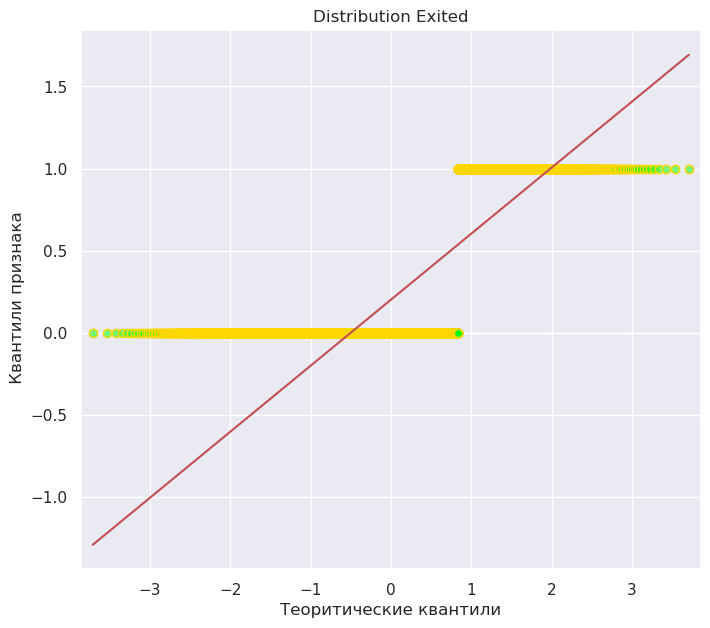

In [17]:
# С помощью цикла пройдёмся по всем признакам, на каждый признак выводим график qqplot
for x in list(df.columns):
        sns.set_palette('bright')
        fig, ax = plt.subplots(figsize=(8, 7))
        sm.qqplot(df[x], line='s', ax=ax, markerfacecolor='#00FF0080', 
                       markeredgecolor='#FFD700')
        ax.set_title(f"Distribution {x}")
        ax.set_ylabel(" Квантили признака")
        ax.set_xlabel("Теоритические квантили")

Распределение не похоже на нормальное, к тому же у нас нет категориальных признаков, исходя из этого, будем использовать метод Спирмена.

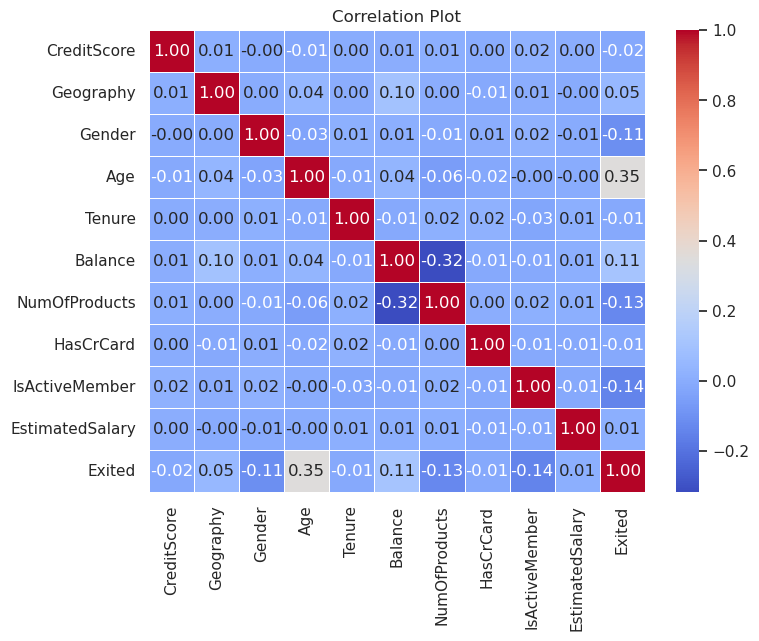

In [18]:
# Проводим корреляцию 
df_corr, p_value = spearmanr(df)
df_corr = pd.DataFrame(df_corr, columns=list(df.columns), index=list(df.columns))

# Отлично, теперь выводим график 
fig , ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax);
ax.set_title('Correlation Plot');

Отличная тепловая карта, сильно коррелирующих признаков нет, наибольшая взаимосвязь наблюдается у пар Баланс/География и Баланс/Количество продуктов, Возраст/Целевой признак. Визуализируем распределение целевого признака.

Exited
0    7677
1    1949
Name: Exited, dtype: int64 



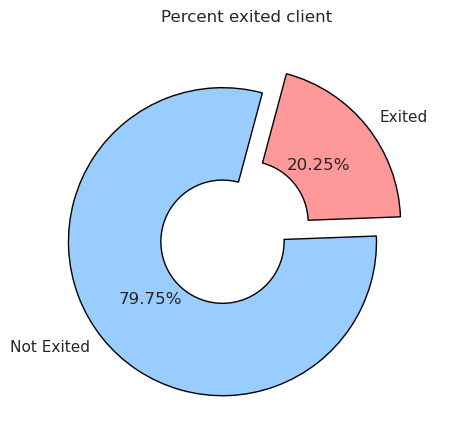

In [19]:
# Группируем данные для отображения 
group_exited_client = df['Exited'].groupby(df['Exited']).count()
print(group_exited_client, '\n')

# Строим плоскость  
fig, ax = plt.subplots(figsize=(5, 5))

# Рисуем график 
plt.pie(group_exited_client, labels=['Not Exited', 'Exited'], 
        autopct='%1.2f%%', colors=['#99CCFF', '#FF9999'],
        wedgeprops=dict(width=0.6, edgecolor='black', linewidth=1), 
        explode=(0.2, 0), startangle=75);

# Добавляем название
ax.set_title('Percent exited client');

Целевой признак не сбалансирован, при разбивке на векторы будем применять стратификацию. Проверим распеределение целевого признака от номинативных признаков.

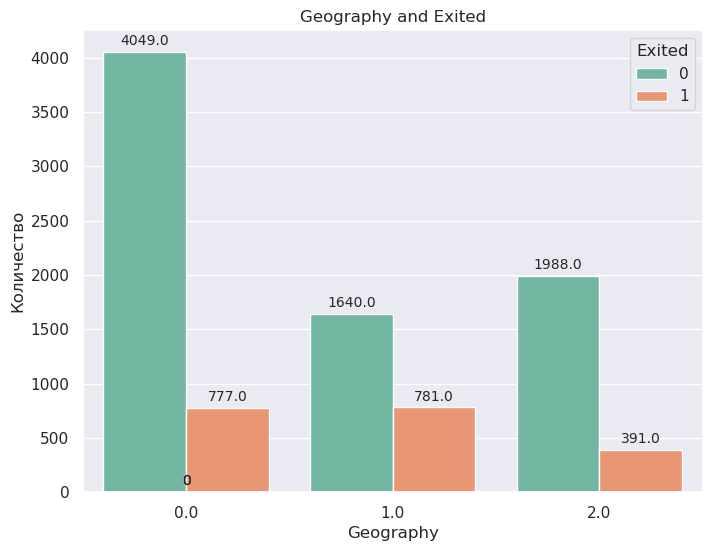

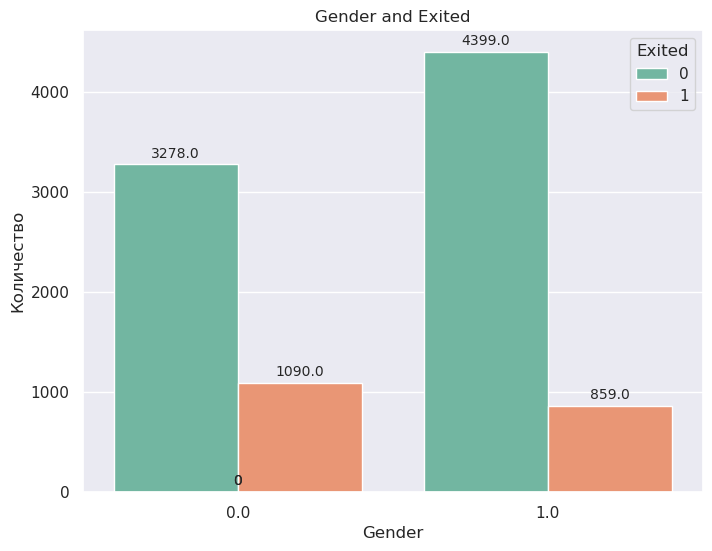

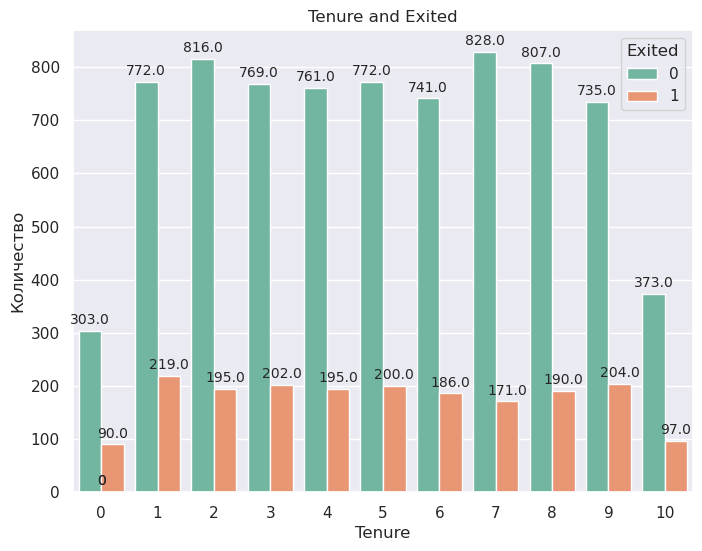

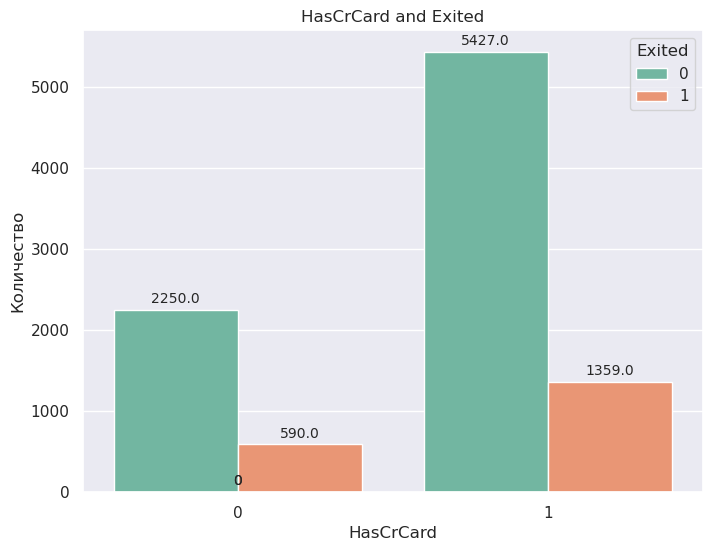

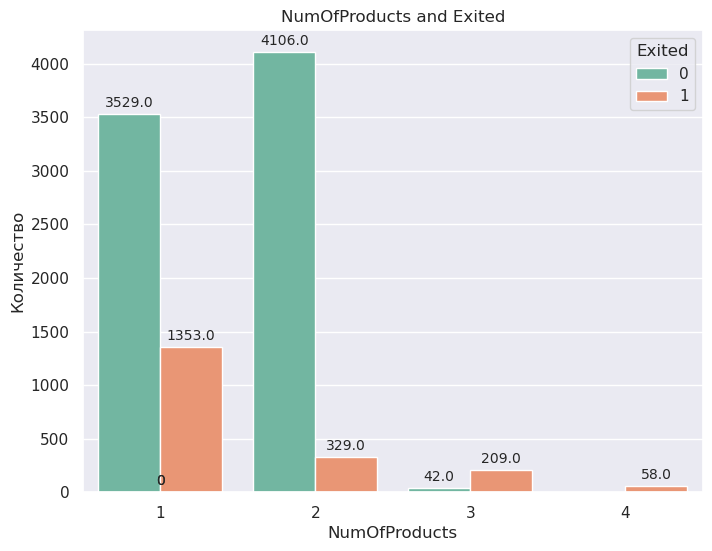

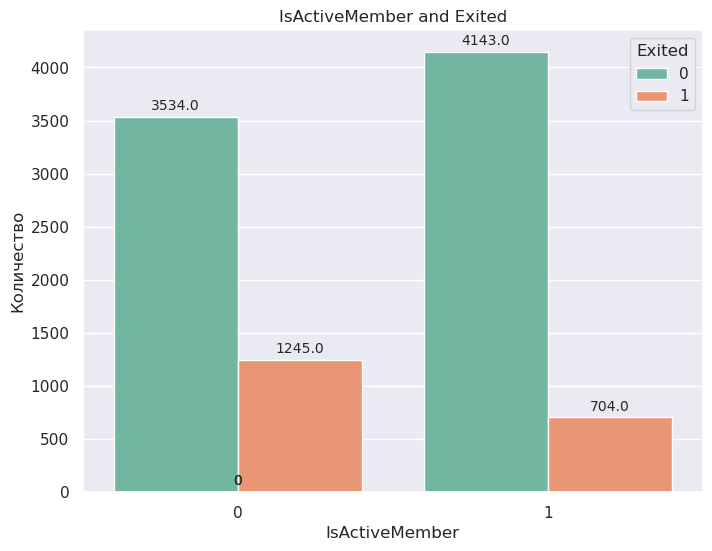

In [20]:
# С помощью цикла переберём признаки и построим график 
for feature in nom_cols:
    # Отобразим плоскость, поменяем палитру, выводим график
    sns.set_palette("Set2")
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(df, x=feature, hue='Exited')

    # Добавим надписи
    for x in ax.patches:
        ax.annotate(
            f'{x.get_height()}', (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='baseline',
                    fontsize=10, xytext=(0, 5), 
                    textcoords='offset points'
                )
    
    # Поменяем названия 
    ax.set_title(f'{feature} and Exited')
    ax.set_ylabel('Количество')
        

* Распределение по стране: Плохая ситуация в Германии, самый большой отток, примерно
1/3 клиентов ушло, у Франции и Испании ~1/5.

* Распеределение по гендеру: Отток мужчин ~1/5, женщин ~1/3.

* Распределение по кол-ву лет: На всех показателях разбиение от ~1/3 до ~1/5.

* Распределение наличия кредитной карты: У клиентов не имеющих кредитную карту соотношения ушедших клиентов ~1/4, так же и у имеющих ~1/4.

* Распределение по кол-ву продуктов: Клиенты у которых было 4 продукта ушли все, у клиентов с 3-мя продуктами отток примерно в 4 раза превышает лояльных клиентов, у клиентов с 1 продуктов отток ~1/3, у клеинтов с 2 продуктами очень хорошее соотношение оттока ~1/12.

* Распределение по активности: У неактивных клиентов отток ~1/3, у активны отток ~1/6.

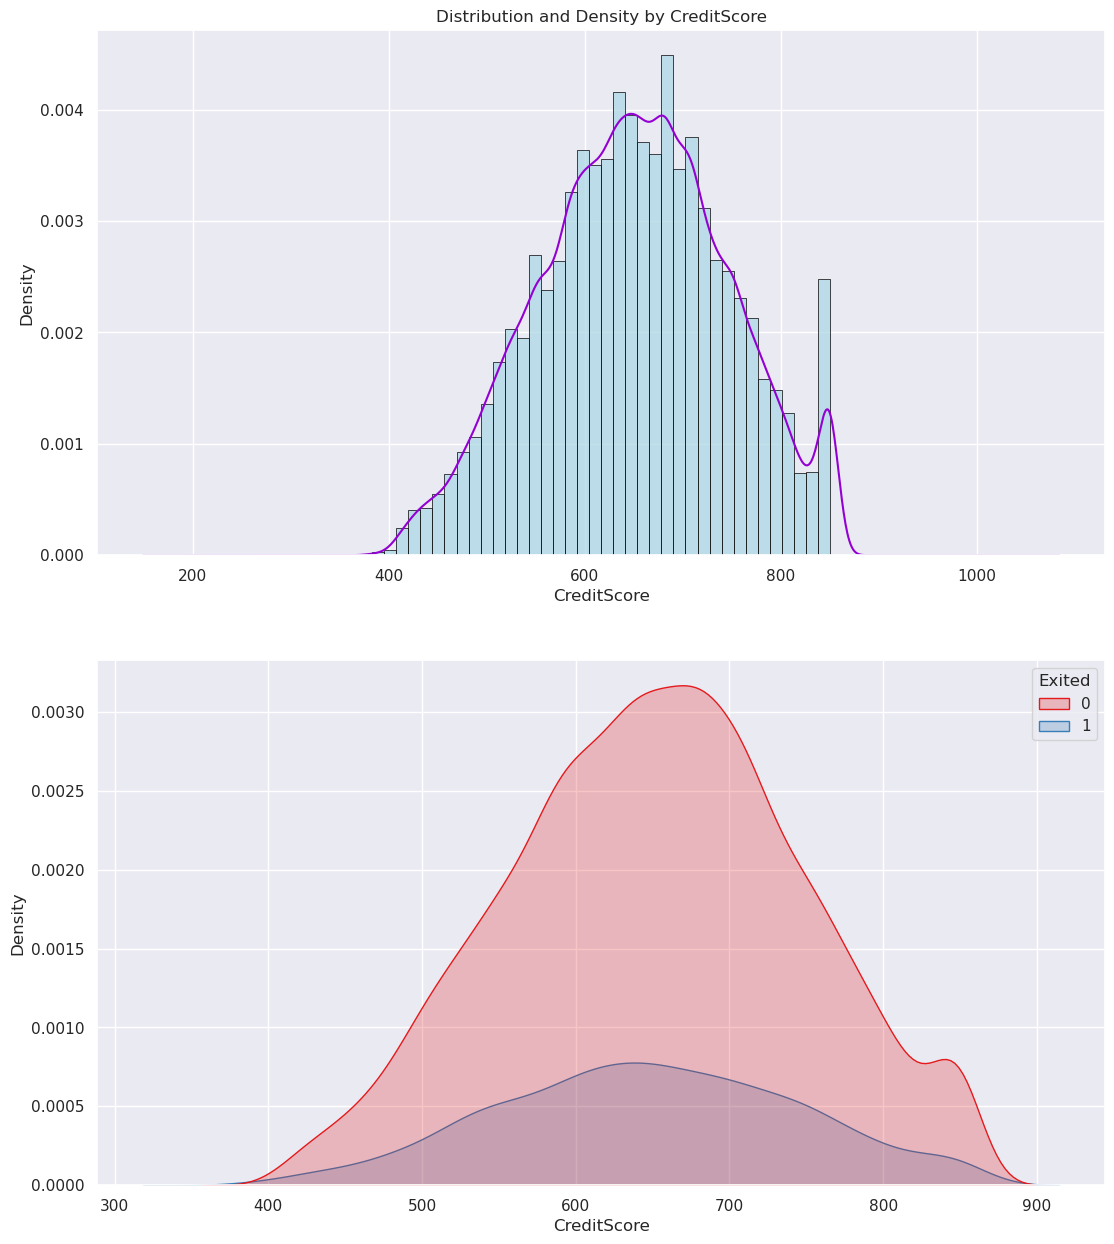

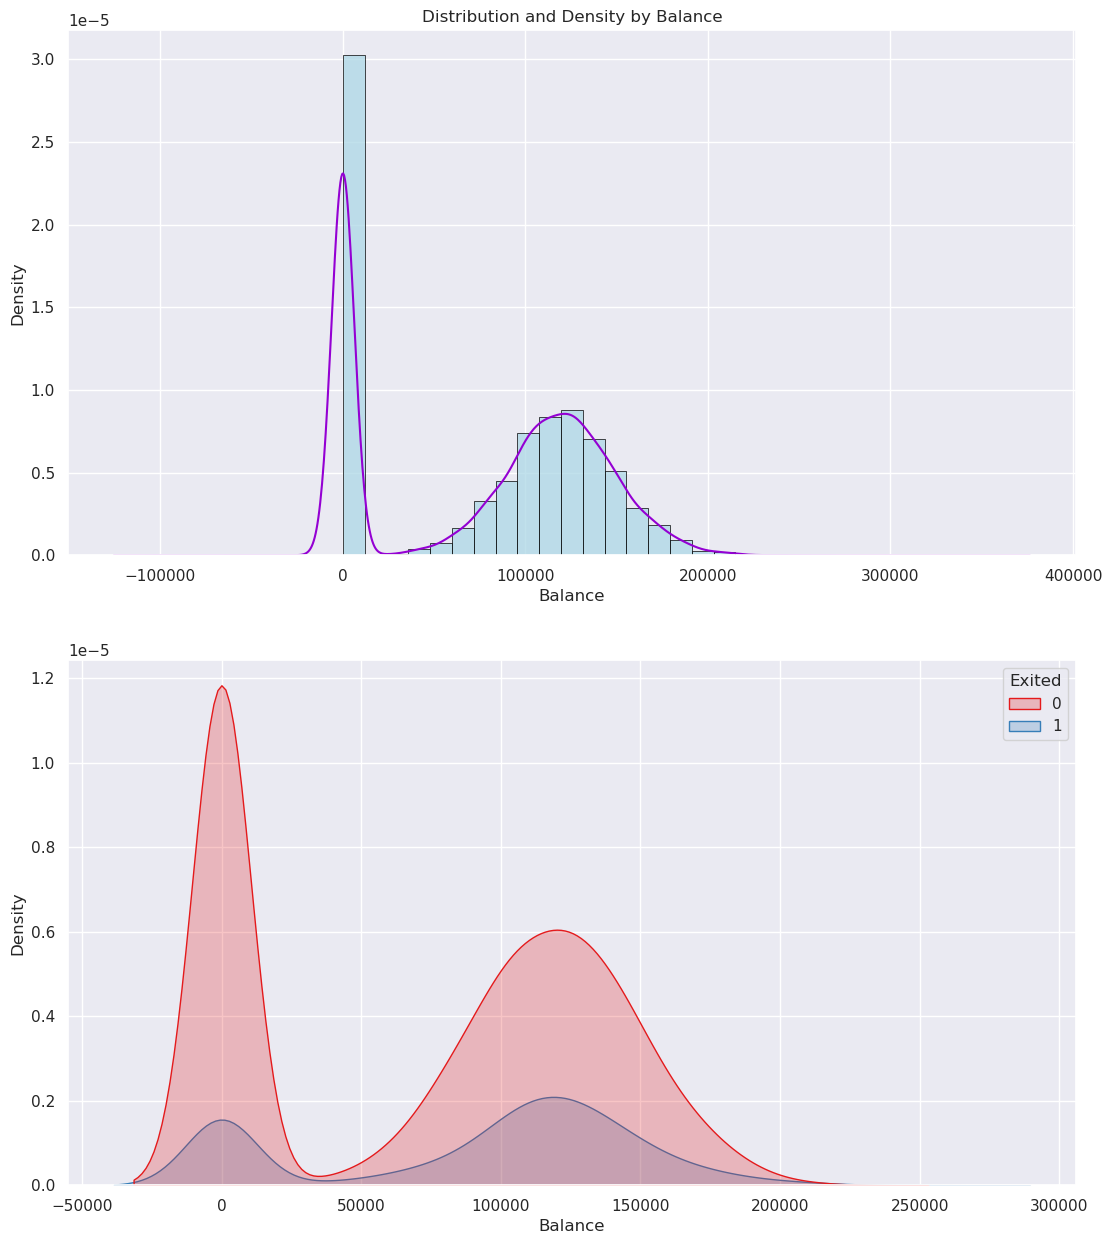

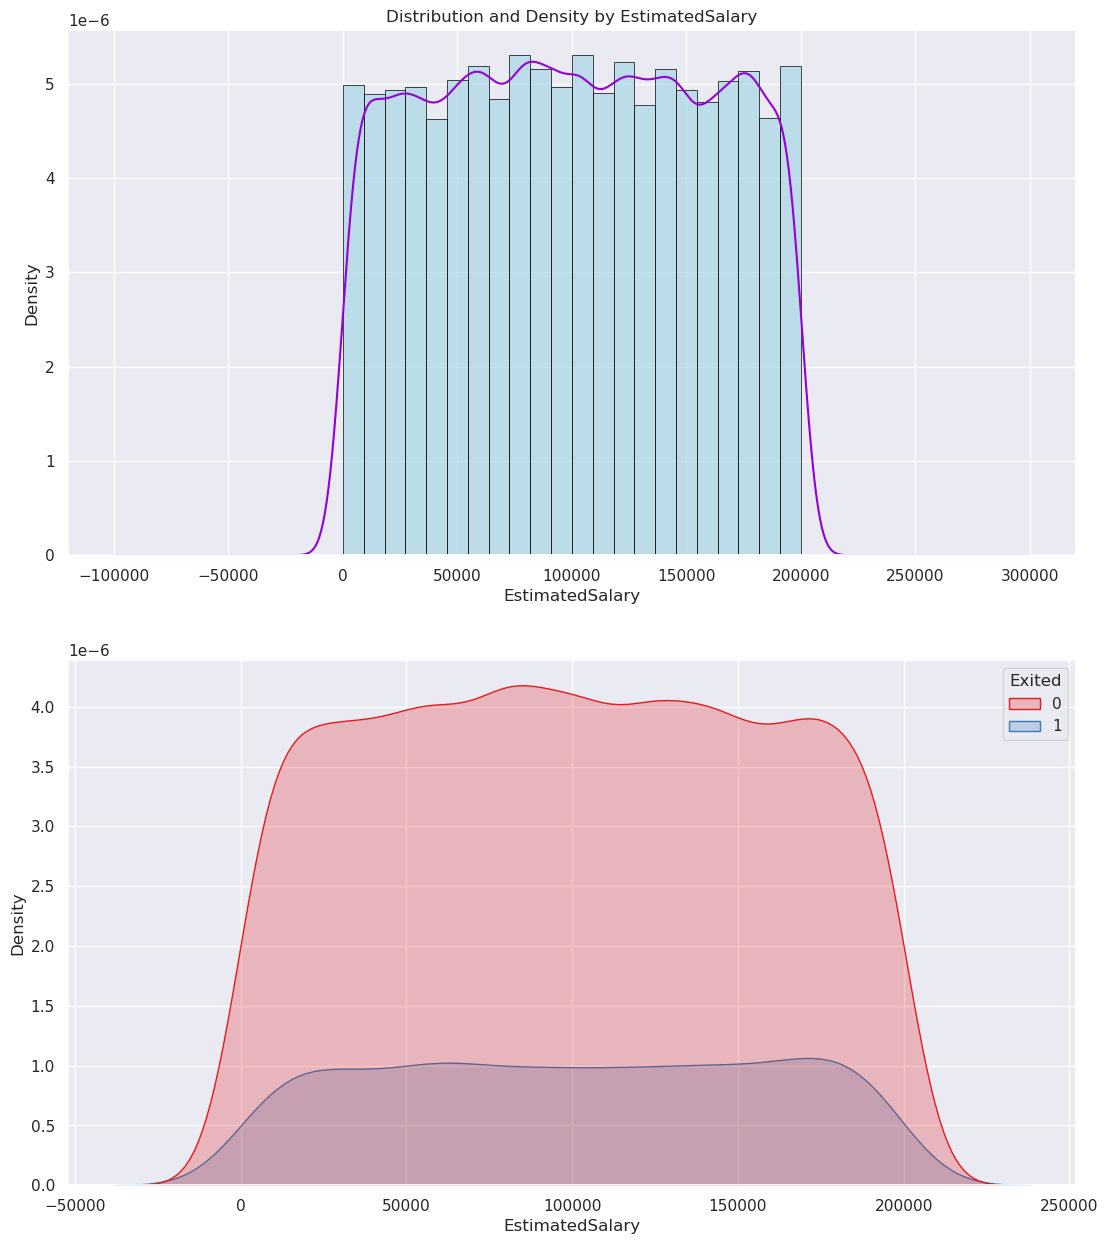

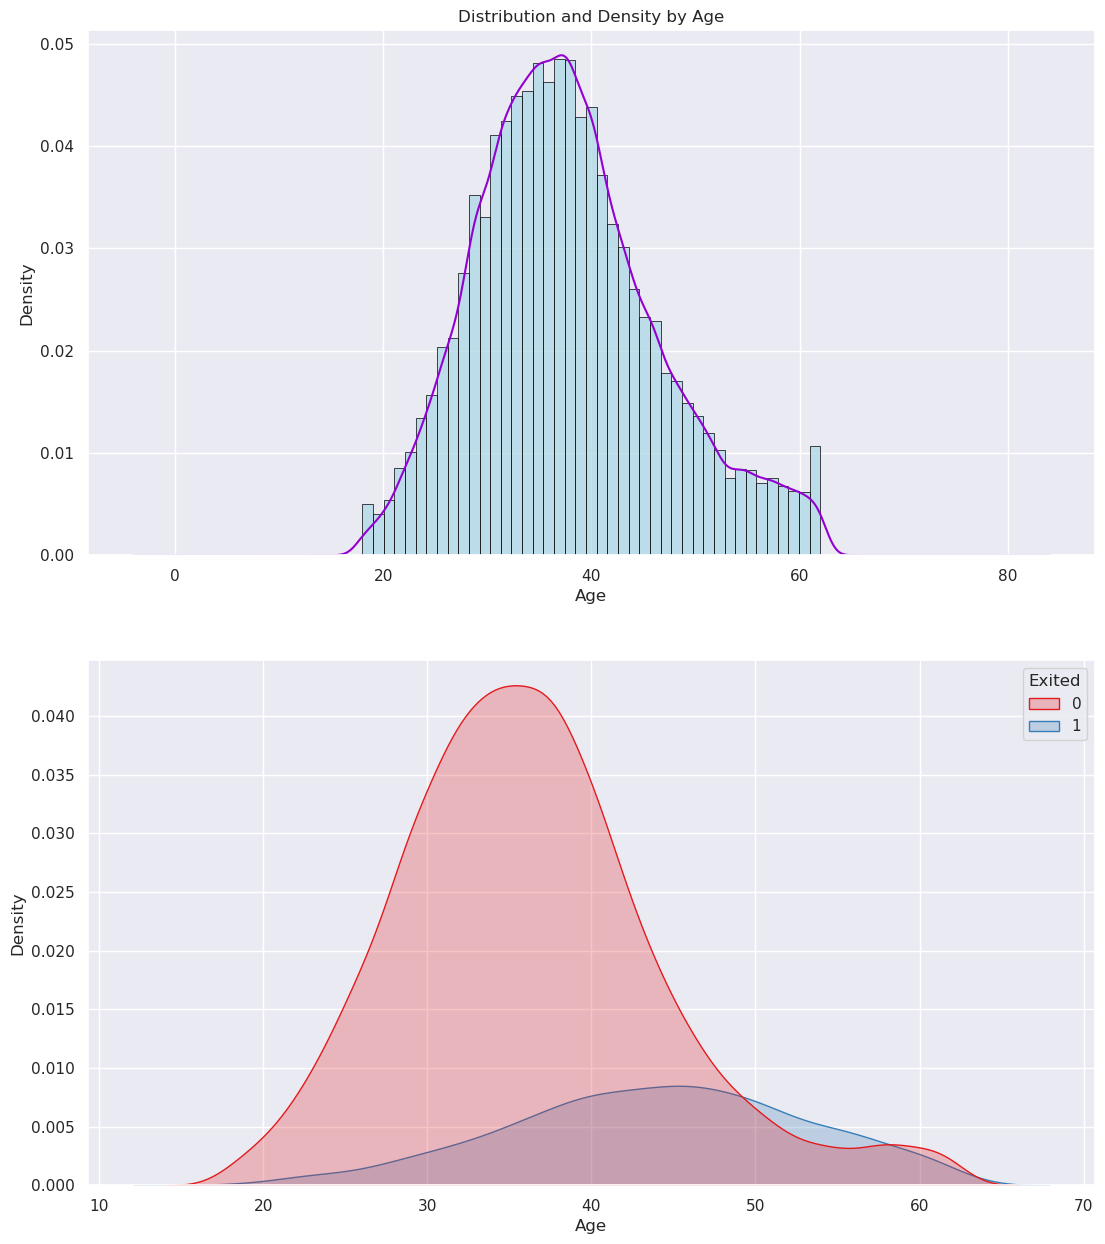

In [21]:
for feature in num_cols:
    fig, ax = plt.subplots(figsize=(13,15), ncols=1, nrows=2)
    sns.histplot(data=df, x=feature, stat='density', color='#ADD8E6', 
                linewidth=0.5, edgecolor='black', ax=ax[0])
    df[feature].plot.kde(bw_method=0.1, color='#9400D3', ax=ax[0])

    sns.kdeplot(data=df, x=feature, hue='Exited', ax=ax[1], 
                fill=True, palette='Set1')
    ax[0].set_title(f'Distribution and Density by {feature}')
    plt.show();

Вероятность плотности хорошая, есть небольшие пеньки от нормального распределения, но они незначительны. Прослеживается некоторая тенденция по признакам:
* Большая часть оттока клиента приходится на кредитный рейтинг от ~500 до ~800, у лояльных от ~500 до ~850

* По балансу лояльные клиенту сгруппированны около нуля и от ~75_000 до ~175_000, 
у ушедших больше сгруппированно от ~75_000 до ~15_000. 

* По признаку ЗП прослеживается тренд, с увеличением ЗП немного увеличивается отток клиентов.

* По возрасту клиенты чаще уходят от ~30 до ~60, лояльные клиенты сгруппированны на отметках от ~18 до ~63.

Рассмотрим более детально распределение количественных признаков от количества продуктов.

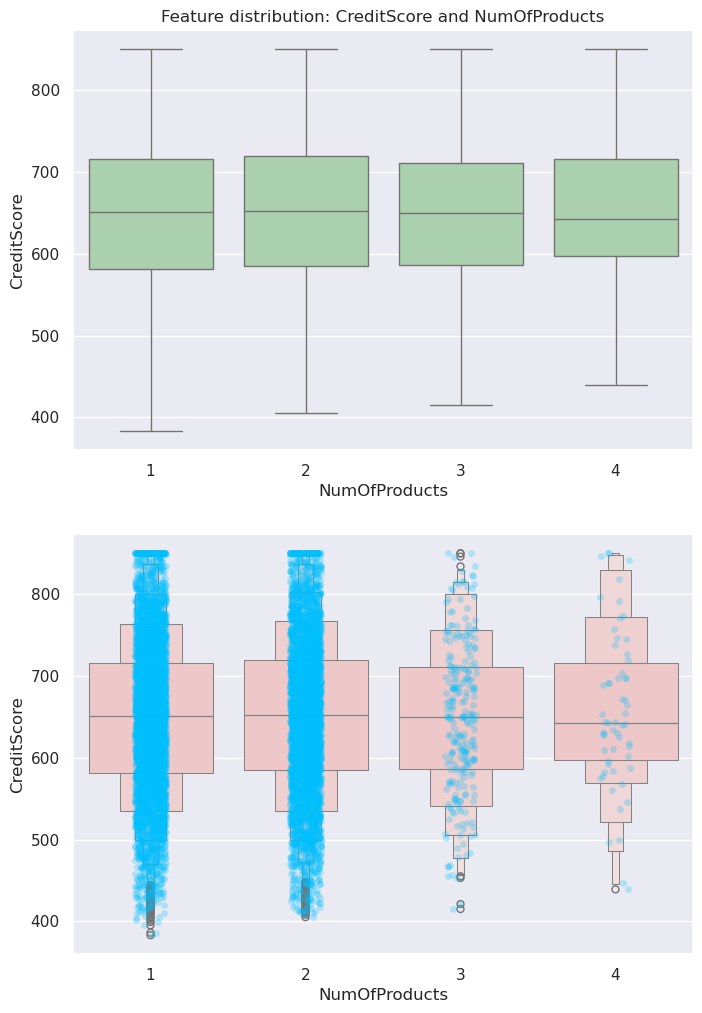

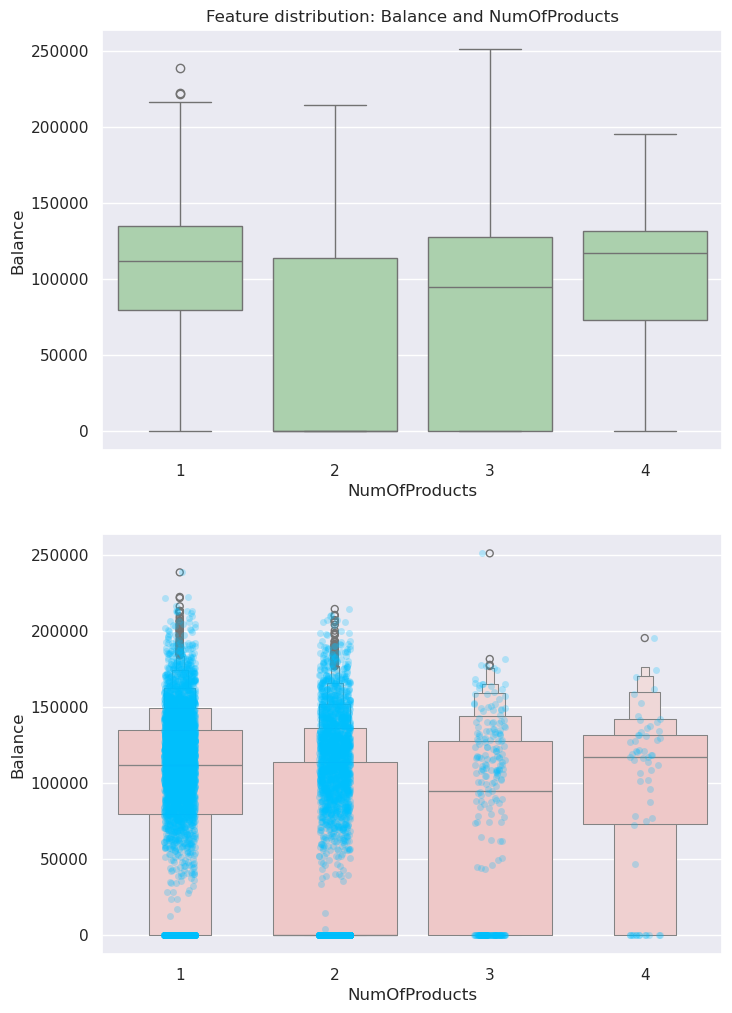

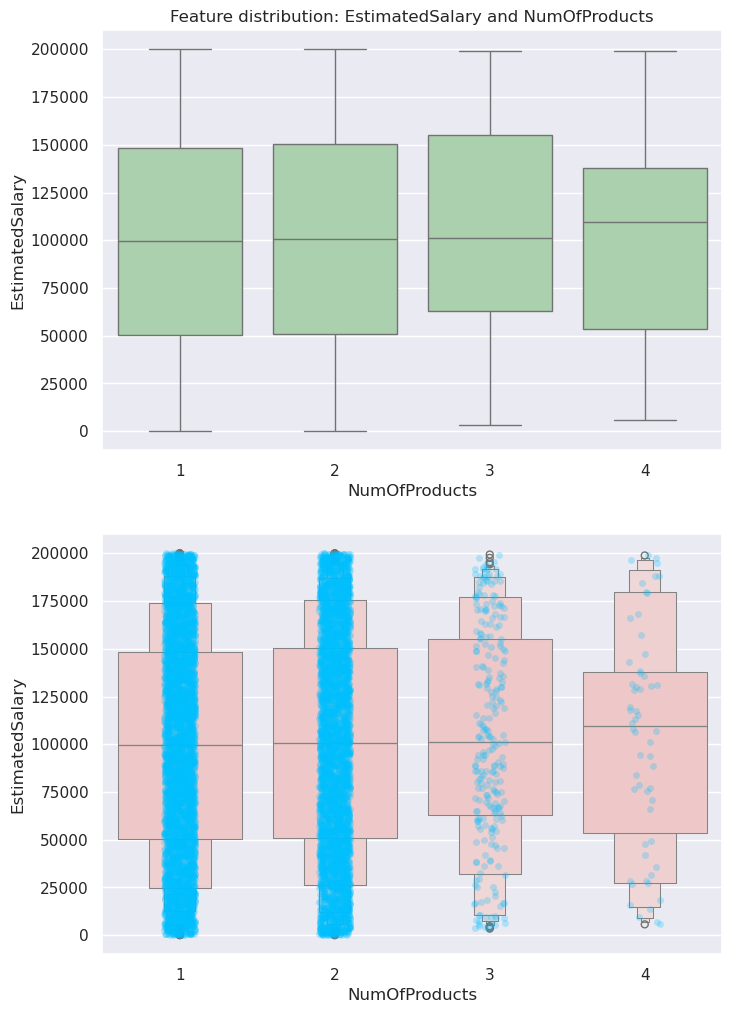

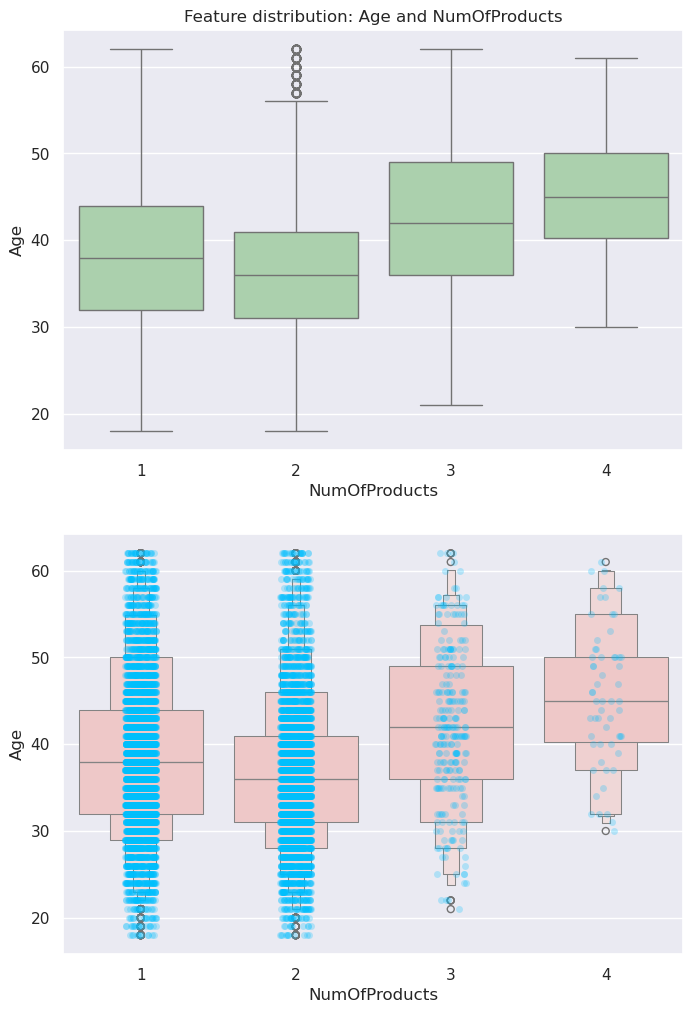

In [22]:
# С помощью цикла переберём список признаков
for feature in num_cols:
    # Отображаем плоскость 
    fig, ax = plt.subplots(figsize=(8, 12), ncols=1, nrows=2)
    
    # Выводим графики 
    sns.boxplot(data=df, x='NumOfProducts', y=feature, ax=ax[0], 
                color='#A5D6A7')
    sns.boxenplot(data=df, x='NumOfProducts', y=feature, ax=ax[1], 
                color='#F4C2C2', showfliers=True, k_depth=5)
    
    # Дополнительно выводим точки данных на втором графике,
    # для наглядности плотности parallel_coordinates
    sns.stripplot(data=df, x='NumOfProducts', y=feature, ax=ax[1], 
                alpha=0.25, color='#00BFFFBF')
    
    # Выводим название 
    ax[0].set_title(f'Feature distribution: {feature} and NumOfProducts')

Как мы видим по графикам признаки зарботной платы и кредитного рейтинга имеют похожее распределение по кол-ву продуктов, возраст и баланс отличаются, так же стоит отметить, что очень малая часть клиентов имеет 3 и 4 продукта. Более детально рассмотрим признак страны.

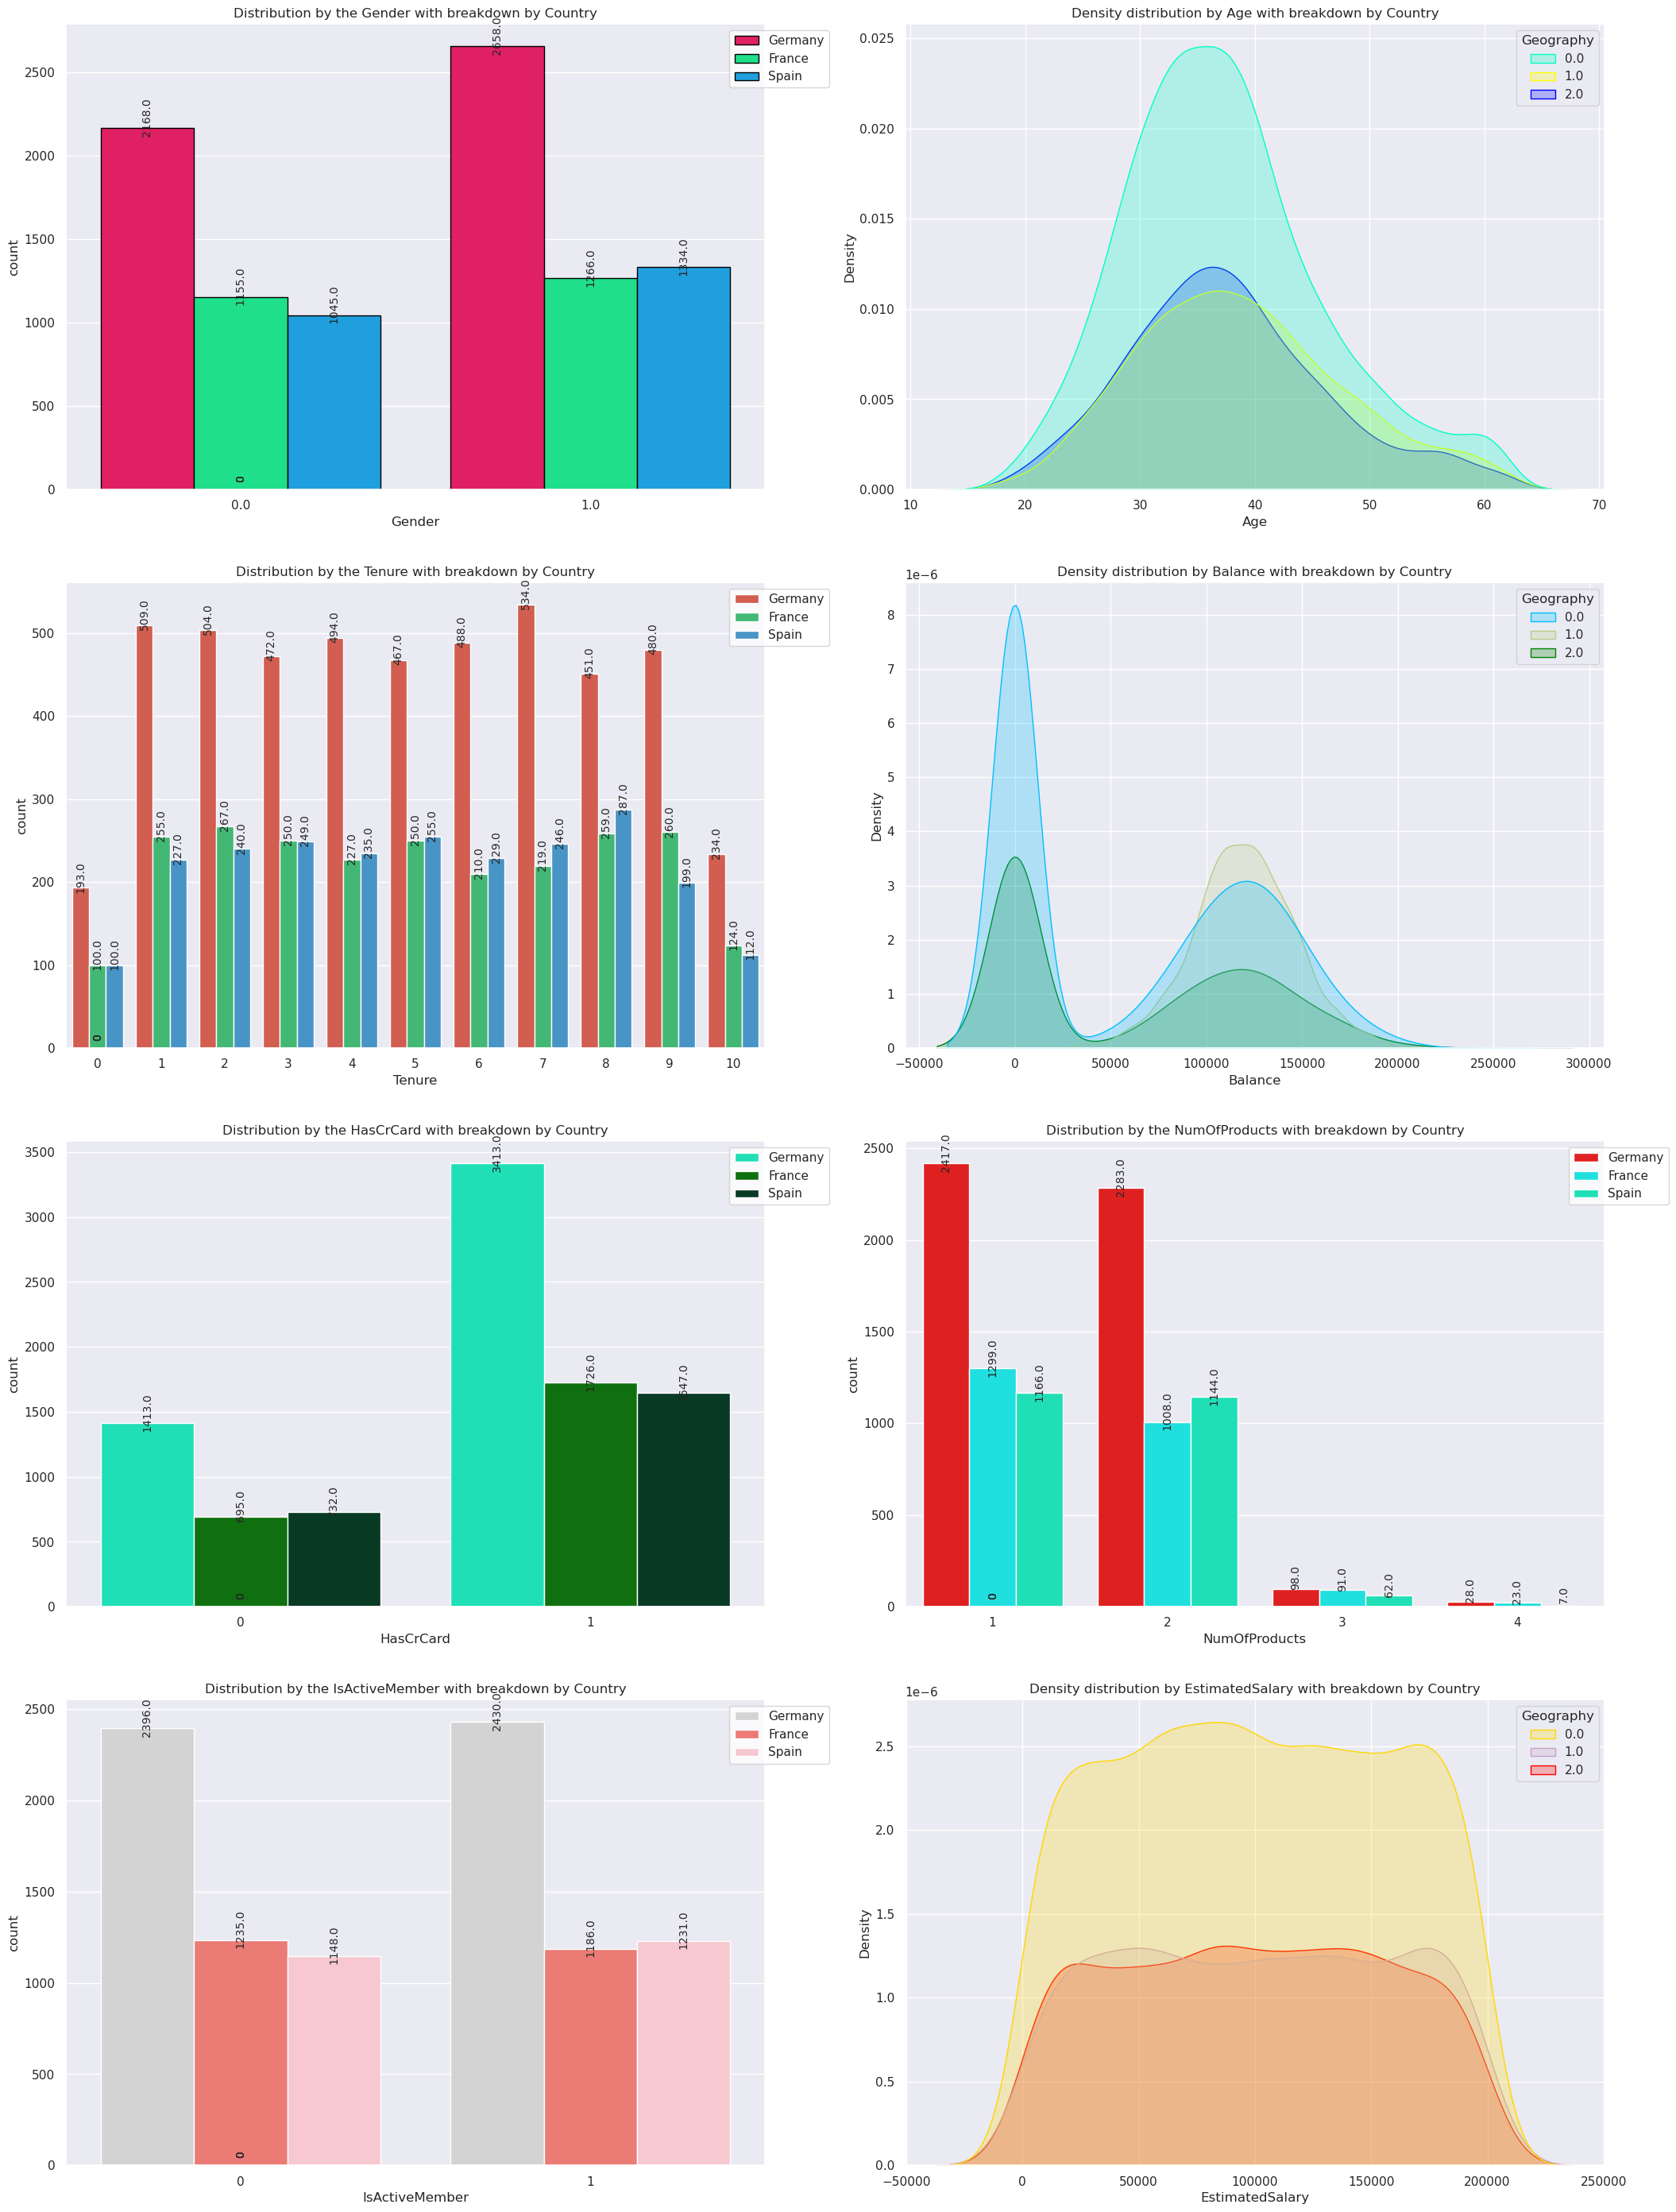

In [23]:
# Отобразим плоскость для вывода графиков 
fig, ax = plt.subplots(figsize=(25,35), nrows=4, ncols=2)

# Составим списки цветов 
palette_0 = ['#FF005A80', '#00FF8D80', '#00A9FF80']
palette_1 = ['#00FFC880', '#FFFF0080', '#0000FF80']
palette_2 = ['#e74c3c', '#2ecc71', '#3498db']
palette_3 = ['#00BFFF', '#BCCC8A', '#008000']
palette_4 = ['#00FFC8', '#008000', '#004225']
palette_5 = ['#FF0000', '#00FFFF', '#00FFC8']
palette_6 = ['#D3D3D3', '#FF6961', '#FFC0CB']
palette_7 = ['#FFD700', '#C8A2C8', '#FF0000']

# Проверим сколько клиентов по гендеру в какой стране 
sns.countplot(df, x='Gender', hue='Geography', ax=ax[0, 0], 
              palette=palette_0, edgecolor='black')
ax[0, 0].set_title(f"Distribution by the Gender with breakdown by Country")

# Взглянем на плотность распределения возраста от стран
sns.kdeplot(df, x='Age', hue='Geography', palette=palette_1, 
            ax=ax[0, 1], fill=True)
ax[0, 1].set_title(f"Density distribution by Age with breakdown by Country")

# Выводим график признака кол-во лет с банком от географии 
sns.countplot(df, x='Tenure', hue='Geography', ax=ax[1, 0], palette=palette_2)
ax[1, 0].set_title(f"Distribution by the Tenure with breakdown by Country")

# Посмотрим на распределение плотности баланса 
sns.kdeplot(df, x='Balance', hue='Geography', ax=ax[1, 1], fill=True,
            palette=palette_3)
ax[1, 1].set_title(f"Density distribution by Balance with breakdown by Country")

# Смотрим на признак имеет ли клиент кредитную карту
sns.countplot(df, x='HasCrCard', hue='Geography', ax=ax[2, 0], 
              palette=palette_4)
ax[2, 0].set_title(f"Distribution by the HasCrCard with breakdown by Country")

# Отобразим признак кол-во продуктов от страны
sns.countplot(df, x='NumOfProducts', hue='Geography', ax=ax[2, 1],
              palette=palette_5)
ax[2, 1].set_title(f"Distribution by the NumOfProducts with breakdown by Country")

# Проверим активность клиента по странам 
sns.countplot(df, x='IsActiveMember', hue='Geography', ax=ax[3, 0],
              palette=palette_6)
ax[3, 0].set_title(f"Distribution by the IsActiveMember with breakdown by Country")

# Посмотрим на распределение плотности относительно ЗП
sns.kdeplot(df, x='EstimatedSalary', hue='Geography', ax=ax[3, 1], 
            fill=True, palette=palette_7)
ax[3, 1].set_title(f"Density distribution by EstimatedSalary with breakdown by Country")

# Для удобства редактирования зафиксируем индексы расположения
coordinates = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 0)]

# Добавим точное кол-во над каждым столбом, 
# сначала переберём координаты, затем патчи графика
for coor in coordinates:
    for x in ax[coor].patches:
        # Добавляем и редактируем надписи над каждым столбцом
        ax[coor].annotate(
            f'{x.get_height()}', (x.get_x() + x.get_width() / 2, 
                x.get_height()), ha='center', va='center',
                fontsize=10, xytext=(0, 10), textcoords='offset points',
                rotation=90)
        
        # Для лучшего отображения меняем расположение легенды и цвет фона 
        ax[coor].legend(['Germany', 'France', 'Spain'], loc='upper right', 
                        bbox_to_anchor=(1.1, 1))\
            .get_frame().set_facecolor('#FFFFFF00')
        

plt.show()

* 0.0 - В Франции в 2 раза больше мужчин и женщин, нежели в Германии и Испании, у них примерно одинаковое количество.

* 0.1 - У всех стран большая часть клиентов сгруппирована от ~23 до ~55.

* 1.0 - График похож на распределение по гендеру, в Германии и Испании +- одинковое количество, в Франции ~2 раза больше.

* 1.1 - Тут уже намного интереснее, Франция имеет огромный хвост в районе 0, у Испании меньше в ~2 раза, самая большая группа клиентов от ~50_000 до ~180_000 баланса имеет Германия, за ней следует Франция и у Испании очень малое кол-во клиентов имеют такой баланс.

* 2.0 - Ситуация опять схожая с графиками (0, 0), (1, 0), показатель у Германии и Испании +- равено, у Франции опять показатель примерно в 2 раза больше. Большая часть клиентов имеет кредитную карту.

* 2.1 - У Франции показатели выше по каждому кол-ву продуктов, Германия занимает второе место по кол-ву продуктов 1, 3, 4, Испания обогнала Германию по 2 продуктам.

* 3.0 - У всех стран разбивка хорошая, +- схожее количесвто клиентов.

* 3.1 - У франции пик ЗП сгруппирован от ~50_000 до ~105_000, Германия имеет два пика от ~25_000 до ~60_000 и от ~155_000 до ~170_000, у Испании более сглаженные данные, можно сказать, что пик находится от ~70_000 до ~155_000.

Посмотрим более детально на зависимость количественных признаков от возраста, с разбивкой по номинативным признакам.

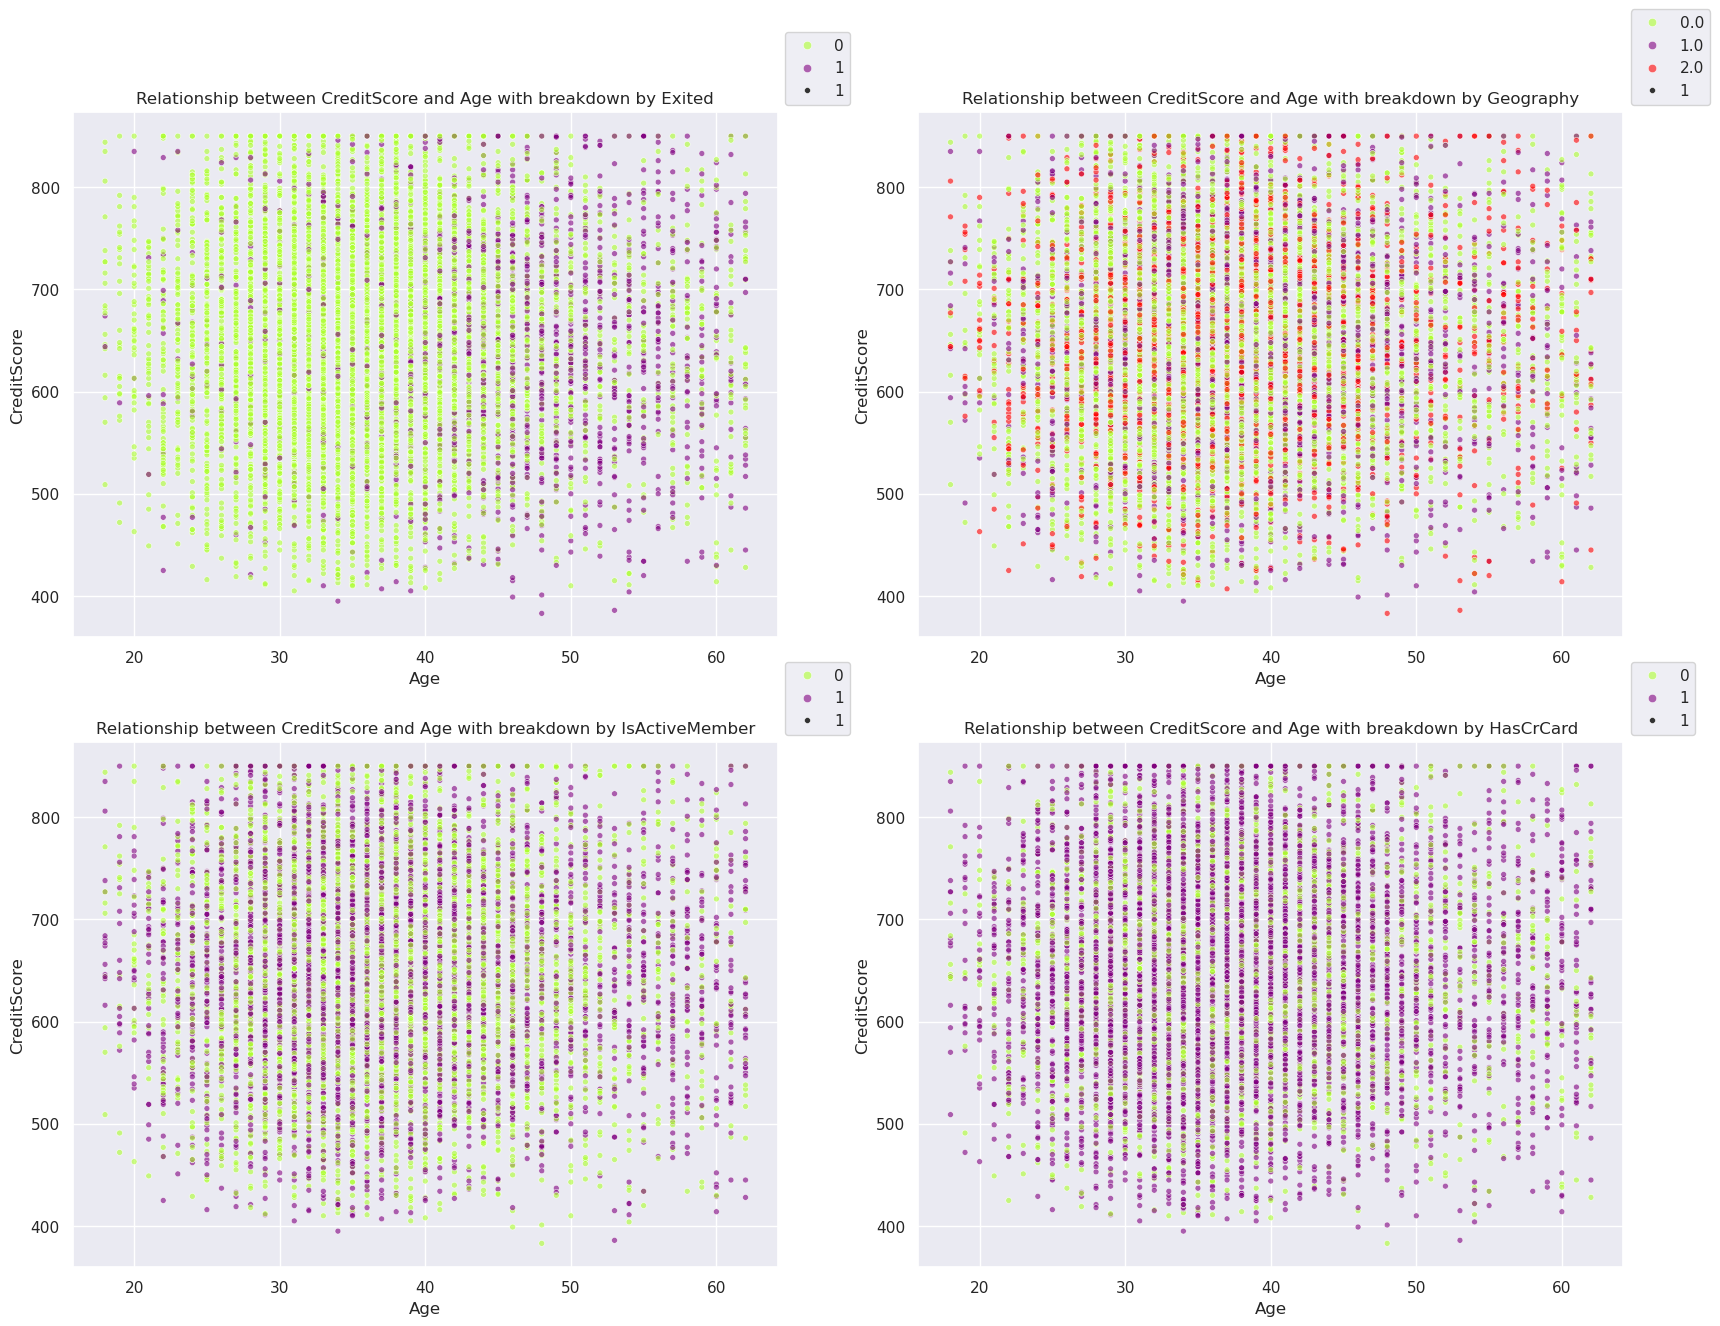

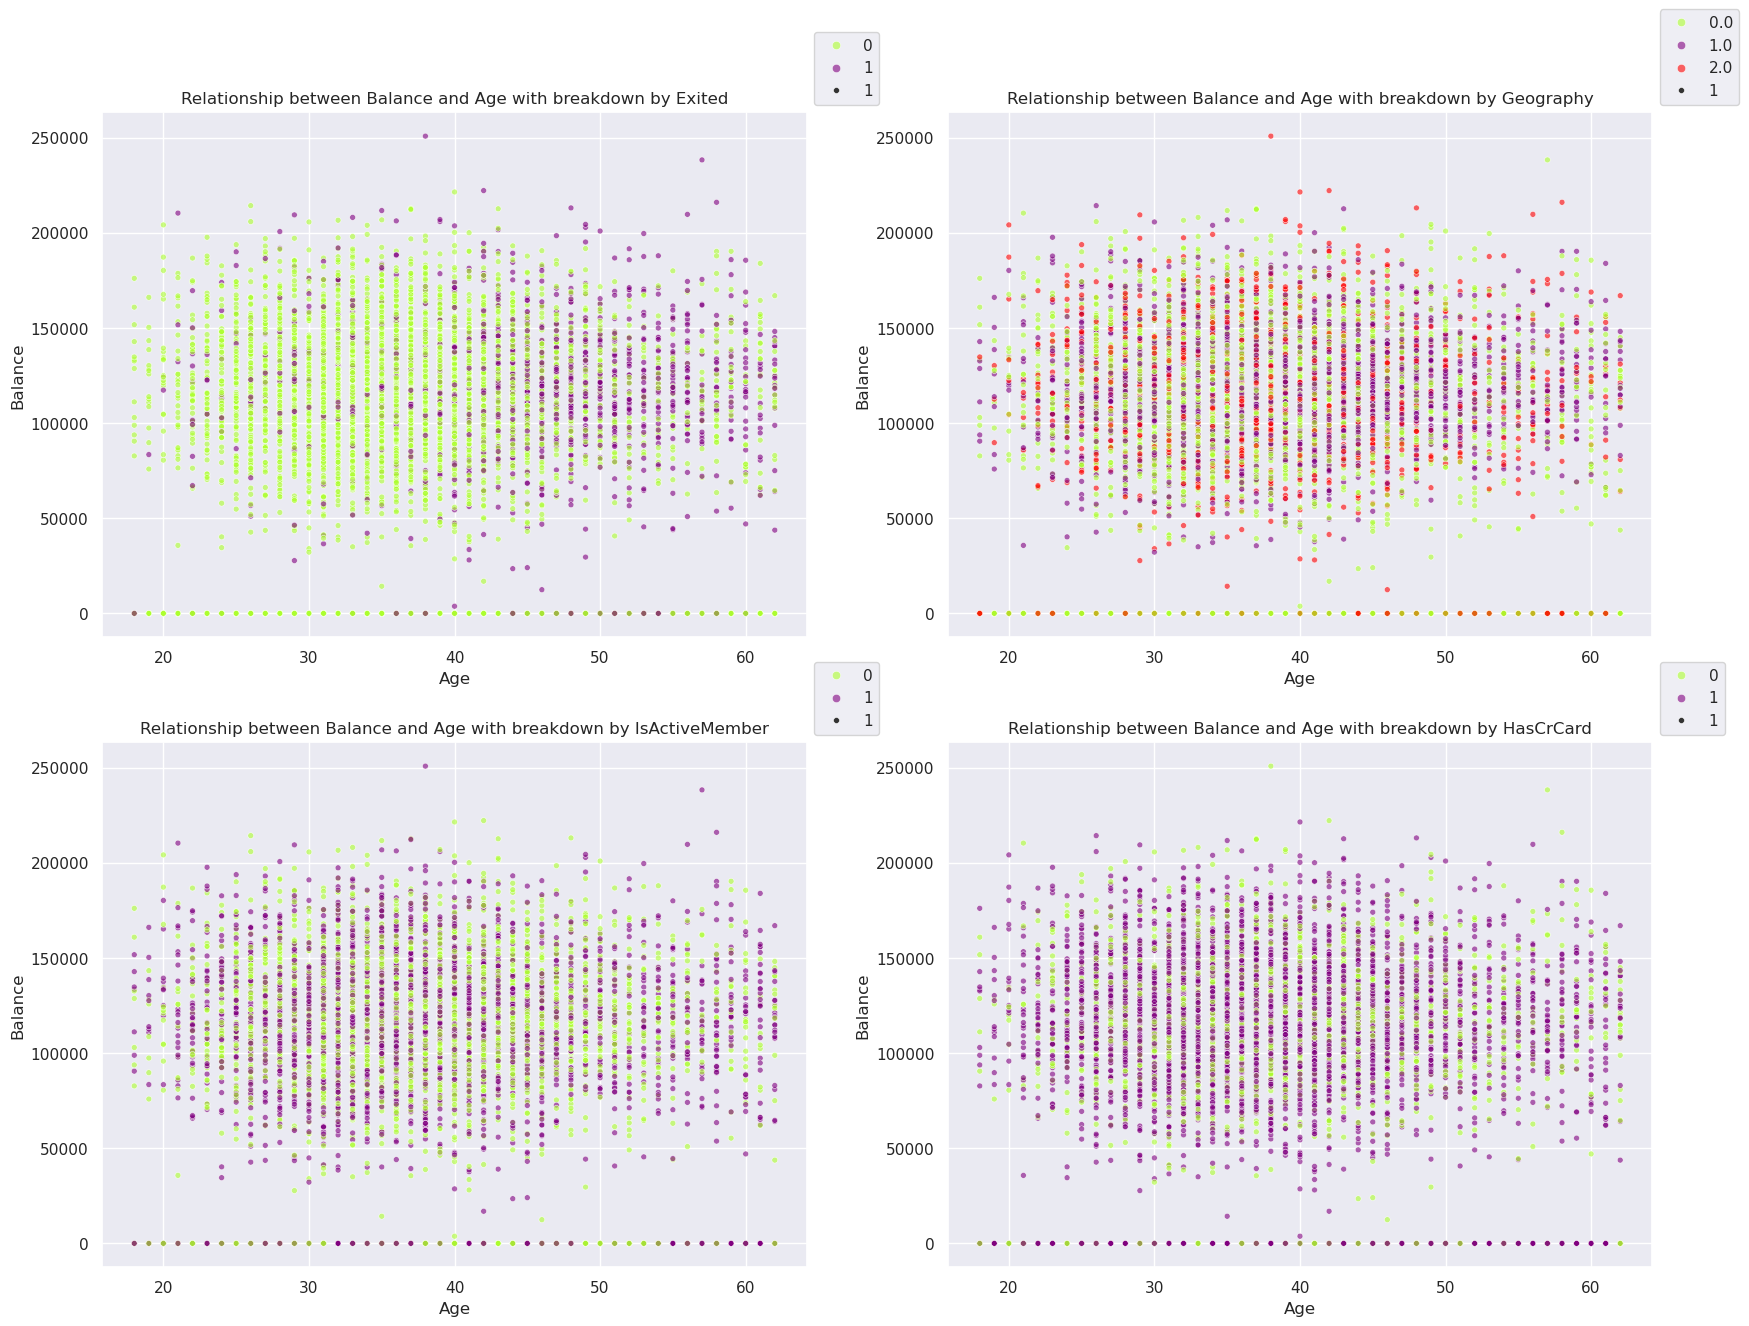

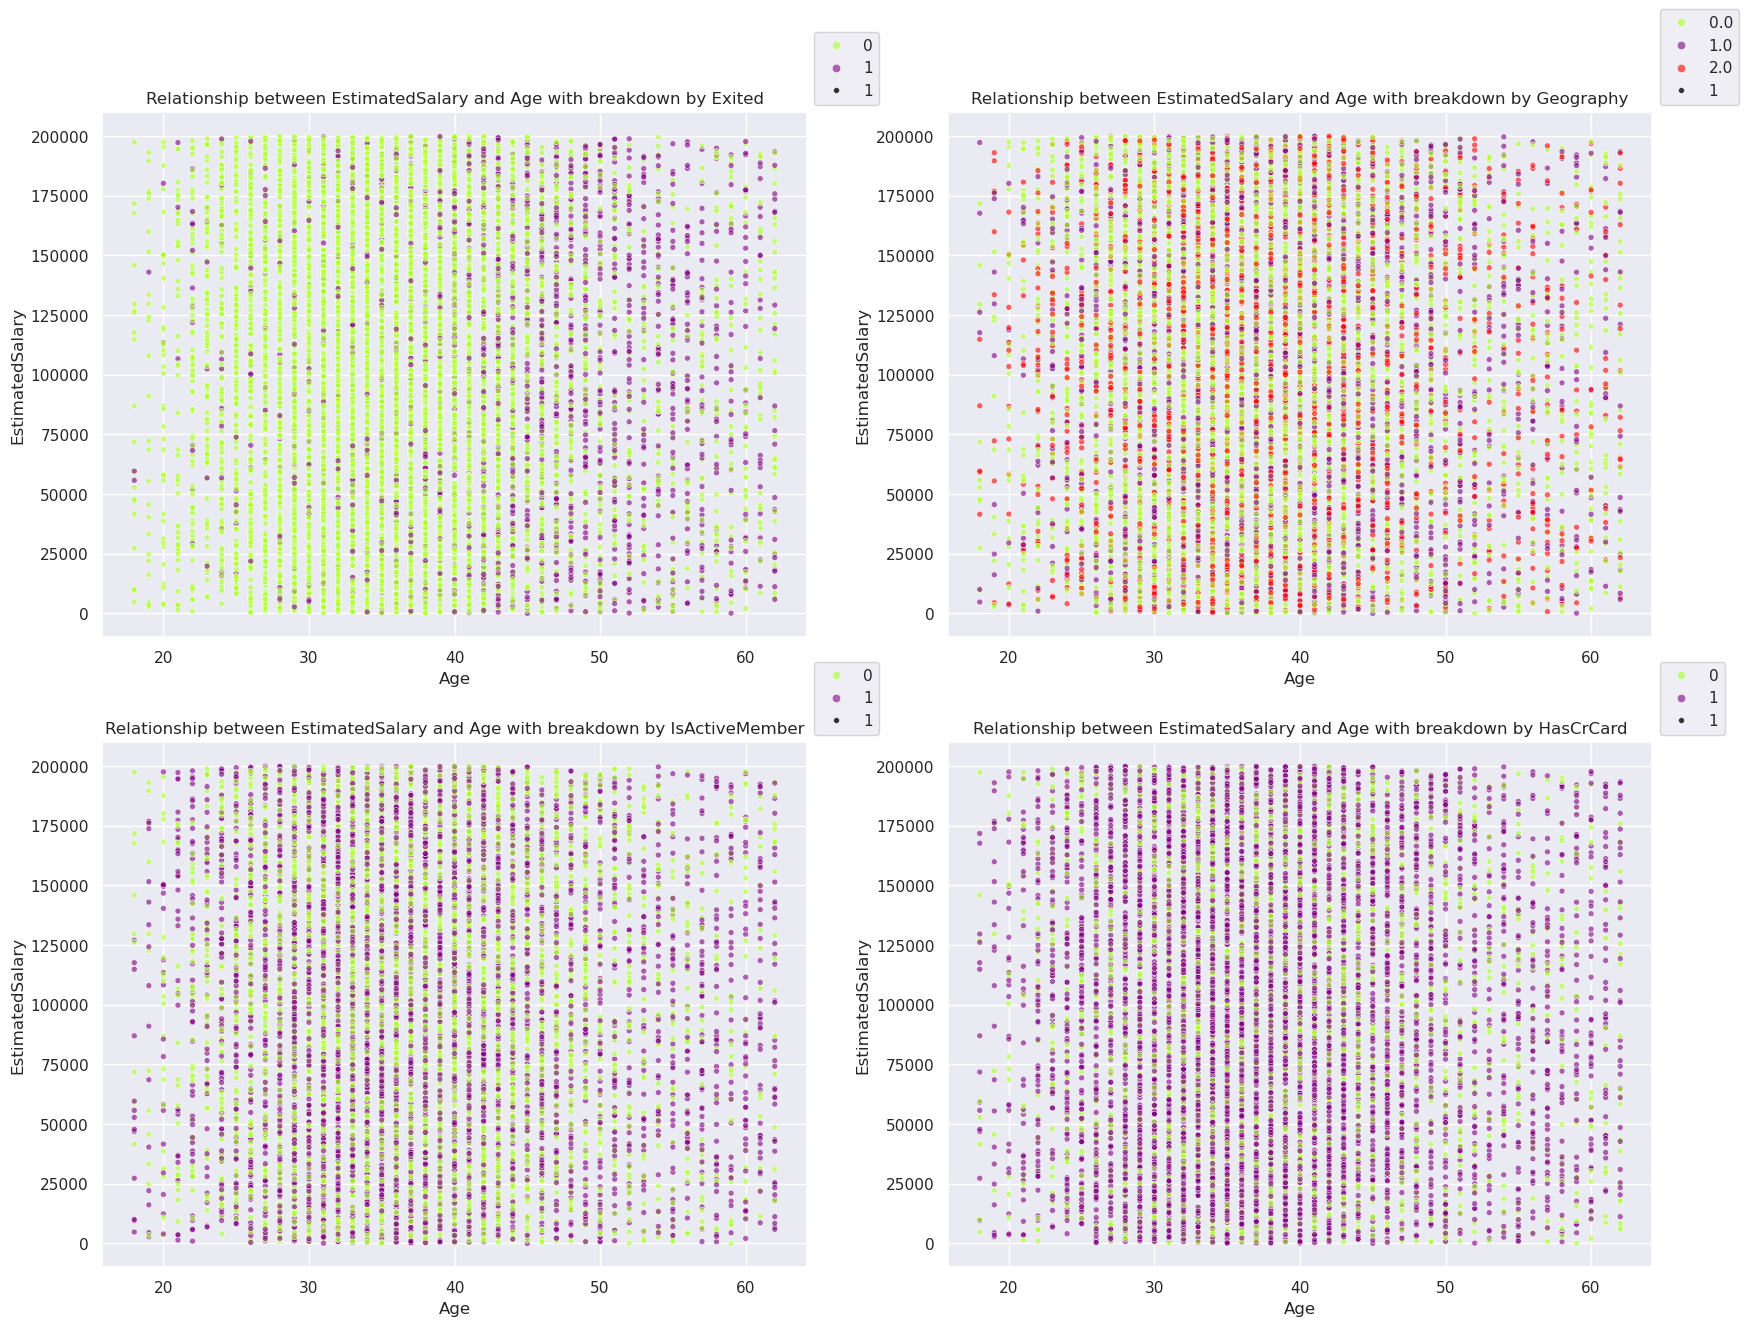

In [24]:
# Составим палитру отображения 
palette_sc = ['#ADFF2F99', '#80008099', '#FF000099']
# С помощью цикла переберём список с признаками
for feature in num_cols:
    # Чтобы не вывести распределение возраст-возраст напишем условие
    if feature == 'Age':
        pass
    else:
        fig, ax= plt.subplots(figsize=(20, 15), ncols=2, nrows=2)
        sns.scatterplot(df, x='Age', y=feature, palette=palette_sc, 
                        hue='Exited', size=1, ax=ax[0, 0])
        ax[0, 0].set_title(f"Relationship between {feature} and Age with breakdown by Exited")

        sns.scatterplot(df, x='Age', y=feature, palette=palette_sc, 
                        hue='Geography', size=1, ax=ax[0, 1])
        ax[0, 1].set_title(f"Relationship between {feature} and Age with breakdown by Geography")

        sns.scatterplot(df, x='Age', y=feature, palette=palette_sc, 
                        hue='IsActiveMember', size=1, ax=ax[1, 0])
        ax[1, 0].set_title(f"Relationship between {feature} and Age with breakdown by IsActiveMember")

        sns.scatterplot(df, x='Age', y=feature, palette=palette_sc, 
                        hue='HasCrCard', size=1, ax=ax[1, 1])
        ax[1, 1].set_title(f"Relationship between {feature} and Age with breakdown by HasCrCard")
        
        ax_lst = [(0 ,0), (0, 1), (1, 0), (1, 1)]
        for x in ax_lst:
            ax[x].legend(loc='lower left', bbox_to_anchor=(1, 1))

1. Кредитный рейтинг и возраст, линейной  зависимости нет, данные расположены хаотично.

    Разбивки:

* 0.0 - Ушедшие клиенту сгруппированы по возрасту, большая часть ушла  от 40 лет, а лояльные клиенты до 40 лет.

* 0.1 - Никакиой зависимости от распределения нет, страна не имеет ни какого влияния.

* 1.0 - Распределение по активному клиенту также никак не влиет.

* 1.1 - Имеет ли клиент кредитную карту не имеет влияния, кредитная карта есть даже у клиентов с низми кредитным рейтингом.

2. Баланс и возраст, так же не имеет линейной зависимости.

    Разбивки:

* 0.0 - Ушедшие клиенту сгруппированы от 40 лет, лояльные до 40.

* 0.1 - По стране никакой зависимости не наблюдается.

* 1.0 - По активному клиенту также никакой зависимости.

* 1.1 - И от признака наличия кк аналогичная ситуация.

3. Заработная плата и возраст, абсолютно никакой зависимости нет.

    Разбивки:

* 0.0 - Лояльные сгруппированны до 40, ушедшие после 40.

* 0.1 - Зависимости нет от Страны.

* 1.0 - Взаимосвязи от активного клиента тоже нет.

* 1.1 - И по признаку наличия кредитной карты зависимоти нет.

### 3.0 Построение модели

Разобъём данные на вектор правильных ответов и обучающие данные, так же нужно нормализовать количественные признаки, будем использовать StandartScaler.

In [25]:
# Создаём объект StandartScaler
scaler = StandardScaler()

# Сразу создаём копию 
df_std = df.copy()

# И с помощью цикла переберём наши признаки
for col in num_cols:
    df_std[col] = scaler.fit_transform(df_std[[col]])

# Проверяем 
df_std.head()

CreditScore  Geography  Gender       Age  Tenure   Balance  NumOfProducts  \
0    -0.330309        0.0     0.0  0.479282       2 -1.226774              1   
1    -0.444790        2.0     0.0  0.365625       1  0.116386              1   
2    -1.547974        0.0     0.0  0.479282       8  1.332056              3   
3     0.502283        0.0     0.0  0.138311       1 -1.226774              2   
4     2.073800        2.0     0.0  0.592939       2  0.784746              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1         0.021480       1  
1          0               1         0.216090       0  
2          1               0         0.240239       1  
3          0               0        -0.109299       0  
4          1               1        -0.365608       0

In [26]:
# Разбиваем выборку
X = df_std.drop('Exited', axis=1)
y = df_std['Exited']

# А теперь разбиваем на обучающую, валидационную и тестову выборку 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=13, 
                                                      stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
                                                    test_size=0.5,
                                                    random_state=13,
                                                    stratify=y_valid)



# Проверяем размерность 
print(f'X_train: {X_train.shape} \nX_valid: {X_valid.shape} \nX_test: {X_test.shape}\n')
print(f'y_train: {y_train.shape} \ny_valid: {y_valid.shape} \ny_test: {y_test.shape} \n')

# И проверяем разбивку целевого признака
print(f"y_train: \n{y_train.value_counts()}\n")
print(f"y_valid: \n{y_valid.value_counts()}\n")
print(f"y_test: \n{y_test.value_counts()}\n")

X_train: (6738, 10) 
X_valid: (1444, 10) 
X_test: (1444, 10)

y_train: (6738,) 
y_valid: (1444,) 
y_test: (1444,) 

y_train: 
0    5374
1    1364
Name: Exited, dtype: int64

y_valid: 
0    1151
1     293
Name: Exited, dtype: int64

y_test: 
0    1152
1     292
Name: Exited, dtype: int64



Напишем нашу первую модель, начнём с простого, логистическая регрессия:

In [27]:
# Напишем модель 
lr_ml = LogisticRegression(random_state=13)

# Обучаем её 
lr_ml.fit(X_train, y_train)

# Предсказываем
lr_ml_pred_train = lr_ml.predict(X_train)
lr_ml_pred_valid = lr_ml.predict(X_valid)

# Выводим метрики 
print(f"Accuracy Train: {round(accuracy_score(y_train, lr_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, lr_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, lr_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, lr_ml_pred_valid), 2)}")

Accuracy Train: 0.82
F1 Train: 0.38 

Accuracy Valid: 0.82
F1 Valid: 0.41


Модель показала неплохую точность, но метрика гармонического среднеге между полнотой и точностью показывает плохой результат.

Используем модель наивного Байеса:

In [28]:
# Пишем модель и обучаем её 
naiv_ml = GaussianNB()
naiv_ml.fit(X_train, y_train)

# Предсказываем 
naiv_ml_pred_train = naiv_ml.predict(X_train)
naiv_ml_pred_valid = naiv_ml.predict(X_valid)

# Выводим метрики 
print(f"Accuracy Train: {round(accuracy_score(y_train, naiv_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, naiv_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, naiv_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, naiv_ml_pred_valid), 2)}")

Accuracy Train: 0.83
F1 Train: 0.45 

Accuracy Valid: 0.83
F1 Valid: 0.49


Ситуация аналогичная с моделью логистической регрессии.

KNN:

In [29]:
# Пишем модель и обучаем её 
knn_ml = KNeighborsClassifier()
knn_ml.fit(X_train, y_train)

# Предсказываем
knn_ml_pred_train = knn_ml.predict(X_train)
knn_ml_pred_valid = knn_ml.predict(X_valid)

# Выводим метрики
print(f"Accuracy Train: {round(accuracy_score(y_train, knn_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, knn_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, knn_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, knn_ml_pred_valid), 2)}")

Accuracy Train: 0.87
F1 Train: 0.61 

Accuracy Valid: 0.82
F1 Valid: 0.43


Модель ближайших соседей больше подстроилась под тренировачную выборку, хоть метрика F1 лучше, чем у моделей выше, на тренировачной выборке, на валидационной показала результаты примерно такие же. 

Tree:

In [30]:
# Пишем модель и обучаем 
tree_ml = DecisionTreeClassifier(random_state=13)
tree_ml.fit(X_train, y_train)

# Предсказываем 
tree_ml_pred_train = tree_ml.predict(X_train)
tree_ml_pred_valid = tree_ml.predict(X_valid)

# Выводим метрики 
print(f"Accuracy Train: {round(accuracy_score(y_train, tree_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, tree_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, tree_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, tree_ml_pred_valid), 2)}")

Accuracy Train: 1.0
F1 Train: 1.0 

Accuracy Valid: 0.78
F1 Valid: 0.5


С решающим деревом всё иначе, модель полностью подстроилась под тренировачную выборку, на валидационной показала плохие результаты, но не хуже чем у моделей выше.

SVC:

In [31]:
# Строим модель и обучаем 
svc_ml = SVC(random_state=13)
svc_ml.fit(X_train, y_train)

# Предсказываем 
svc_ml_pred_train = svc_ml.predict(X_train)
svc_ml_pred_valid = svc_ml.predict(X_valid)

# Выводим метрики 
print(f"Accuracy Train: {round(accuracy_score(y_train, svc_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, svc_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, svc_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, svc_ml_pred_valid), 2)}")

Accuracy Train: 0.83
F1 Train: 0.3 

Accuracy Valid: 0.83
F1 Valid: 0.35


Метод опорных векторов тоже показал не высокие результаты.

Random forest:

In [32]:
# Пишем модель и обучаем 
rf_ml = RandomForestClassifier(random_state=13)
rf_ml.fit(X_train, y_train)

# Предсказываем 
rf_ml_pred_train = rf_ml.predict(X_train)
rf_ml_pred_valid = rf_ml.predict(X_valid)

# Выводим метрики 
print(f"Accuracy Train: {round(accuracy_score(y_train, rf_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, rf_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, rf_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, rf_ml_pred_valid), 2)}")

Accuracy Train: 1.0
F1 Train: 1.0 

Accuracy Valid: 0.86
F1 Valid: 0.58


У модели случайного леса явное переобучение, но показала результаты выше на валидационной выборке.

GradientBoosting:

In [33]:
# Пишем модель и обучаем 
gb_ml = GradientBoostingClassifier(random_state=13)
gb_ml.fit(X_train, y_train)

# Предсказывем 
gb_ml_pred_train = gb_ml.predict(X_train)
gb_ml_pred_valid = gb_ml.predict(X_valid)

# И выводим метрики 
print(f"Accuracy Train: {round(accuracy_score(y_train, gb_ml_pred_train), 2)}")
print(f"F1 Train: {round(f1_score(y_train, gb_ml_pred_train), 2)} \n")

print(f"Accuracy Valid: {round(accuracy_score(y_valid, gb_ml_pred_valid), 2)}")
print(f"F1 Valid: {round(f1_score(y_valid, gb_ml_pred_valid), 2)}")

Accuracy Train: 0.87
F1 Train: 0.61 

Accuracy Valid: 0.85
F1 Valid: 0.57


На мой взгляд модель градиентного бустинга справилась с задачей лучше всего, модель не переобучилась и показала достойные результаты на валидационной выборке.

Попробуем подобрать гиперпараметры для каждой модели, будем использовать библиотеку Optuna, постараемся улучшить метрику F1 score, у нас сильный дисбаланс целевого признака, но и точность тоже постараемся повысить.

In [34]:
# Напишем функцию для поиска у модели логистической регресии 
def optuna_lr(trial):
    # Напишем сетку гиперпараметров 
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    intercept_scaling = trial.suggest_int('intercept_scaling', 1, 5, 1)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Пишем модель и обучаем 
    model_lr = LogisticRegression(penalty=penalty, 
                                  fit_intercept=fit_intercept,
                                  intercept_scaling=intercept_scaling,
                                  solver=solver, random_state=13)
    model_lr.fit(X_train, y_train)

    # Получаем метрику
    f1_lr = f1_score(y_valid, model_lr.predict(X_valid))

    return f1_lr

In [35]:
# Функция написана, пора её применить
# Создаём объект иследования 
study_lr = optuna.create_study(study_name='LogisticRegression', direction='maximize')

# Запускаем поиск лучшей комбинации 
study_lr.optimize(optuna_lr, n_trials=30)

[I 2023-12-20 18:52:24,819] A new study created in memory with name: LogisticRegression
[I 2023-12-20 18:52:24,844] Trial 0 finished with value: 0.410958904109589 and parameters: {'penalty': 'l2', 'fit_intercept': True, 'intercept_scaling': 5, 'solver': 'saga'}. Best is trial 0 with value: 0.410958904109589.
[I 2023-12-20 18:52:24,869] Trial 1 finished with value: 0.410958904109589 and parameters: {'penalty': 'l2', 'fit_intercept': True, 'intercept_scaling': 3, 'solver': 'liblinear'}. Best is trial 0 with value: 0.410958904109589.
[I 2023-12-20 18:52:24,886] Trial 2 finished with value: 0.4314606741573034 and parameters: {'penalty': 'l2', 'fit_intercept': False, 'intercept_scaling': 4, 'solver': 'liblinear'}. Best is trial 2 with value: 0.4314606741573034.
[I 2023-12-20 18:52:24,904] Trial 3 finished with value: 0.410958904109589 and parameters: {'penalty': 'l2', 'fit_intercept': True, 'intercept_scaling': 4, 'solver': 'liblinear'}. Best is trial 2 with value: 0.4314606741573034.
[I 20

In [36]:
# Выводим лучшие гиперпараметры и значение метрик
print(f'Лучшие гиперпараметры: {study_lr.best_params}')
print(f'Значение метрик: {round(study_lr.best_value, 2)}')

Лучшие гиперпараметры: {'penalty': 'l1', 'fit_intercept': False, 'intercept_scaling': 3, 'solver': 'saga'}
Значение метрик: 0.43


Оптимизация незначительно повысила качество метрики на валидационной выборке, проведём на тестовой.

In [37]:
# Напишем новую модель и обучаем её
best_lr_ml = LogisticRegression(**study_lr.best_params, random_state=13)
best_lr_ml.fit(X_train, y_train)

# Делаем предсказания на 3-х выборках 
best_lr_ml_pred_train = best_lr_ml.predict(X_train)
best_lr_ml_pred_valid = best_lr_ml.predict(X_valid)
best_lr_ml_pred_test = best_lr_ml.predict(X_test)

# Выводим метрики
print(f'Train: \n {classification_report(y_train, best_lr_ml_pred_train)} \n')
print(f'Valid: \n {classification_report(y_valid, best_lr_ml_pred_valid)} \n')
print(f'Test: \n {classification_report(y_test, best_lr_ml_pred_test)} \n')

Train: 
               precision    recall  f1-score   support

           0       0.84      0.96      0.90      5374
           1       0.65      0.30      0.41      1364

    accuracy                           0.83      6738
   macro avg       0.75      0.63      0.66      6738
weighted avg       0.80      0.83      0.80      6738
 

Valid: 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      1151
           1       0.63      0.33      0.43       293

    accuracy                           0.82      1444
   macro avg       0.74      0.64      0.67      1444
weighted avg       0.80      0.82      0.80      1444
 

Test: 
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      1152
           1       0.68      0.28      0.40       292

    accuracy                           0.83      1444
   macro avg       0.76      0.63      0.65      1444
weighted avg       0.81      0.83      0.80 

Повысить качество мы не смогли, наивного Байеса рассматривать не будем, модель имеет мало гиперпараметров, вряд ли мы сможем хоть как-то улучшить показатели, перейдём к модели ближайших соседей.

In [38]:
# Прописываем функцию 
def optuna_knn(trial):
    # Задаём сетку 
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30, 1)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    leaf_size = trial.suggest_int('leaf_size', 30, 60, 10)

    # Прописываем модель 
    knn_ml = KNeighborsClassifier(n_neighbors=n_neighbors, 
                                  #weights=weights,
                                  leaf_size=leaf_size)
    knn_ml.fit(X_train, y_train)

    # Метрика 
    f1_knn = f1_score(y_valid, knn_ml.predict(X_valid))

    return f1_knn

In [39]:
# Создаём объект иследования 
study_knn = optuna.create_study(study_name='KNN', direction='maximize')

# Запускаем поиск лучшей комбинации 
study_knn.optimize(optuna_knn, n_trials=30)

[I 2023-12-20 18:52:26,075] A new study created in memory with name: KNN
[I 2023-12-20 18:52:26,198] Trial 0 finished with value: 0.3496143958868895 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'leaf_size': 40}. Best is trial 0 with value: 0.3496143958868895.
[I 2023-12-20 18:52:26,297] Trial 1 finished with value: 0.3097112860892388 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'leaf_size': 30}. Best is trial 0 with value: 0.3496143958868895.
[I 2023-12-20 18:52:26,396] Trial 2 finished with value: 0.3496143958868895 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'leaf_size': 30}. Best is trial 0 with value: 0.3496143958868895.
[I 2023-12-20 18:52:26,499] Trial 3 finished with value: 0.3015873015873016 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 50}. Best is trial 0 with value: 0.3496143958868895.
[I 2023-12-20 18:52:26,599] Trial 4 finished with value: 0.3434343434343435 and parameters: {'n_neighbors': 29, 'weights': 'u

In [40]:
# Выводим лучшие гиперпараметры и значение метрик
print(f'Лучшие гиперпараметры: {study_knn.best_params}')
print(f'Значение метрик: {round(study_knn.best_value, 2)}')

Лучшие гиперпараметры: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 50}
Значение метрик: 0.44


Улучили показатели метрики на валидационной выборке, проверим что у нас получилось.

In [41]:
# Напишем новую модель и обучаем её
best_knn_ml = KNeighborsClassifier(**study_knn.best_params)
best_knn_ml.fit(X_train, y_train)

# Делаем предсказания на 3-х выборках 
best_knn_ml_pred_train = best_knn_ml.predict(X_train)
best_knn_ml_pred_valid = best_knn_ml.predict(X_valid)
best_knn_ml_pred_test = best_knn_ml.predict(X_test)

# Выводим метрики
print(f'Train: \n {classification_report(y_train, best_knn_ml_pred_train)} \n')
print(f'Valid: \n {classification_report(y_valid, best_knn_ml_pred_valid)} \n')
print(f'Test: \n {classification_report(y_test, best_knn_ml_pred_test)} \n')

Train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      1364

    accuracy                           1.00      6738
   macro avg       1.00      1.00      1.00      6738
weighted avg       1.00      1.00      1.00      6738
 

Valid: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      1151
           1       0.55      0.36      0.44       293

    accuracy                           0.81      1444
   macro avg       0.70      0.64      0.66      1444
weighted avg       0.79      0.81      0.79      1444
 

Test: 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1152
           1       0.56      0.35      0.43       292

    accuracy                           0.81      1444
   macro avg       0.70      0.64      0.66      1444
weighted avg       0.79      0.81      0.80 

Метрику немного удалось повысить, посмотрим на остальные модели.

In [42]:
# Прописываем функцию 
def optuna_tree(trial):
    # Задаём сетку
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 3, 20, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 30, 1)

    # Строим и обучаем модель 
    tree_ml = DecisionTreeClassifier(random_state=13, criterion=criterion,
                                    max_depth=max_depth, 
                                    min_samples_split=min_samples_split)
    tree_ml.fit(X_train, y_train)

    # Получаем метрику 
    f1_tree = f1_score(y_valid, tree_ml.predict(X_valid))

    return f1_tree


In [43]:
# Создаём объект иследования 
study_tree = optuna.create_study(study_name='Tree', direction='maximize')

# Запускаем поиск лучшей комбинации 
study_tree.optimize(optuna_tree, n_trials=30)

[I 2023-12-20 18:52:29,047] A new study created in memory with name: Tree
[I 2023-12-20 18:52:29,077] Trial 0 finished with value: 0.5836575875486382 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 29}. Best is trial 0 with value: 0.5836575875486382.
[I 2023-12-20 18:52:29,112] Trial 1 finished with value: 0.5145067698259188 and parameters: {'criterion': 'log_loss', 'max_depth': 19, 'min_samples_split': 29}. Best is trial 0 with value: 0.5836575875486382.
[I 2023-12-20 18:52:29,131] Trial 2 finished with value: 0.5144124168514412 and parameters: {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_split': 17}. Best is trial 0 with value: 0.5836575875486382.
[I 2023-12-20 18:52:29,147] Trial 3 finished with value: 0.5067264573991032 and parameters: {'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 20}. Best is trial 0 with value: 0.5836575875486382.
[I 2023-12-20 18:52:29,183] Trial 4 finished with value: 0.5215686274509804 and parameters: {'cri

In [44]:
# Выводим лучшие гиперпараметры и значение метрик
print(f'Лучшие гиперпараметры: {study_tree.best_params}')
print(f'Значение метрик: {round(study_tree.best_value, 2)}')

Лучшие гиперпараметры: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 28}
Значение метрик: 0.59


In [45]:
# Напишем новую модель и обучаем её
best_tree_ml = DecisionTreeClassifier(**study_tree.best_params, random_state=13)
best_tree_ml.fit(X_train, y_train)

# Делаем предсказания на 3-х выборках 
best_tree_ml_pred_train = best_tree_ml.predict(X_train)
best_tree_ml_pred_valid = best_tree_ml.predict(X_valid)
best_tree_ml_pred_test = best_tree_ml.predict(X_test)

# Выводим метрики
print(f'Train: \n {classification_report(y_train, best_tree_ml_pred_train)} \n')
print(f'Valid: \n {classification_report(y_valid, best_tree_ml_pred_valid)} \n')
print(f'Test: \n {classification_report(y_test, best_tree_ml_pred_test)} \n')

Train: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      5374
           1       0.80      0.56      0.66      1364

    accuracy                           0.88      6738
   macro avg       0.85      0.76      0.79      6738
weighted avg       0.88      0.88      0.87      6738
 

Valid: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      1151
           1       0.67      0.52      0.59       293

    accuracy                           0.85      1444
   macro avg       0.77      0.73      0.75      1444
weighted avg       0.84      0.85      0.84      1444
 

Test: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.90      1152
           1       0.65      0.47      0.55       292

    accuracy                           0.84      1444
   macro avg       0.76      0.70      0.73      1444
weighted avg       0.83      0.84      0.83 

При подборе гиперпараметров мы справились с переобучением, метрики немного удалось улучшить, но модель опять таки нам не подходит, слишком низкий показатель.

In [46]:
# Прописываем функцию 
def optuna_svc(trial):
    # Задаём сетку 
    c = trial.suggest_int('C', 1, 10, 1)
    degree = trial.suggest_int('degree', 1, 10, 1)

    # Прописываем модель 
    svc_ml = SVC(C=c,degree=degree)
    svc_ml.fit(X_train, y_train)

    # Метрика 
    f1_svc = f1_score(y_valid, svc_ml.predict(X_valid))

    return f1_svc

In [47]:
# Создаём объект иследования 
study_svc = optuna.create_study(study_name='SVC', direction='maximize')

# Запускаем поиск лучшей комбинации 
study_svc.optimize(optuna_svc, n_trials=30)

[I 2023-12-20 18:52:30,039] A new study created in memory with name: SVC
[I 2023-12-20 18:52:30,981] Trial 0 finished with value: 0.3468834688346884 and parameters: {'C': 1, 'degree': 5}. Best is trial 0 with value: 0.3468834688346884.
[I 2023-12-20 18:52:31,802] Trial 1 finished with value: 0.48543689320388356 and parameters: {'C': 4, 'degree': 4}. Best is trial 1 with value: 0.48543689320388356.
[I 2023-12-20 18:52:32,579] Trial 2 finished with value: 0.3468834688346884 and parameters: {'C': 1, 'degree': 6}. Best is trial 1 with value: 0.48543689320388356.
[I 2023-12-20 18:52:33,504] Trial 3 finished with value: 0.511737089201878 and parameters: {'C': 9, 'degree': 4}. Best is trial 3 with value: 0.511737089201878.
[I 2023-12-20 18:52:34,346] Trial 4 finished with value: 0.5059665871121719 and parameters: {'C': 5, 'degree': 5}. Best is trial 3 with value: 0.511737089201878.
[I 2023-12-20 18:52:35,127] Trial 5 finished with value: 0.4263959390862944 and parameters: {'C': 3, 'degree': 2

In [48]:
# Выводим лучшие гиперпараметры и значение метрик
print(f'Лучшие гиперпараметры: {study_svc.best_params}')
print(f'Значение метрик: {round(study_svc.best_value, 2)}')

Лучшие гиперпараметры: {'C': 7, 'degree': 10}
Значение метрик: 0.52


In [49]:
# Напишем новую модель и обучаем её
best_svc_ml = SVC(**study_svc.best_params)
best_svc_ml.fit(X_train, y_train)

# Делаем предсказания на 3-х выборках 
best_svc_ml_pred_train = best_svc_ml.predict(X_train)
best_svc_ml_pred_valid = best_svc_ml.predict(X_valid)
best_svc_ml_pred_test = best_svc_ml.predict(X_test)

# Выводим метрики
print(f'Train: \n {classification_report(y_train, best_svc_ml_pred_train)} \n')
print(f'Valid: \n {classification_report(y_valid, best_svc_ml_pred_valid)} \n')
print(f'Test: \n {classification_report(y_test, best_svc_ml_pred_test)} \n')

Train: 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      5374
           1       0.88      0.34      0.49      1364

    accuracy                           0.86      6738
   macro avg       0.87      0.67      0.71      6738
weighted avg       0.86      0.86      0.83      6738
 

Valid: 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      1151
           1       0.84      0.38      0.52       293

    accuracy                           0.86      1444
   macro avg       0.85      0.68      0.72      1444
weighted avg       0.86      0.86      0.84      1444
 

Test: 
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      1152
           1       0.85      0.33      0.48       292

    accuracy                           0.85      1444
   macro avg       0.85      0.66      0.70      1444
weighted avg       0.85      0.85      0.83 

После подбора гиперпараметров мы смогли незначительно улучшить показатели, но они всё ещё малы для использования модели.

In [50]:
# Прописываем функцию 
def optuna_rf(trial):
    # Задаём сетку 
    n_estimators = trial.suggest_int('n_estimators', 50, 200, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 
                                                        'log_loss'])
    max_depth = trial.suggest_int('max_depth', 3, 10, 1)

    # Строим модель 
    ml_rf = RandomForestClassifier(random_state=13, 
                                      n_estimators=n_estimators,
                                      criterion=criterion,
                                      max_depth=max_depth)
    ml_rf.fit(X_train, y_train)
    
    # Метрика 
    f1_rf = f1_score(y_valid, ml_rf.predict(X_valid))

    return f1_rf

In [51]:
# Создаём объект иследования 
study_rf = optuna.create_study(study_name='RandomForest', direction='maximize')

# Запускаем поиск лучшей комбинации 
study_rf.optimize(optuna_rf, n_trials=100)

[I 2023-12-20 18:52:57,346] A new study created in memory with name: RandomForest
[I 2023-12-20 18:52:57,822] Trial 0 finished with value: 0.5426008968609866 and parameters: {'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 8}. Best is trial 0 with value: 0.5426008968609866.
[I 2023-12-20 18:52:58,259] Trial 1 finished with value: 0.5398230088495576 and parameters: {'n_estimators': 80, 'criterion': 'gini', 'max_depth': 9}. Best is trial 0 with value: 0.5426008968609866.
[I 2023-12-20 18:52:58,750] Trial 2 finished with value: 0.5327313769751694 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 8}. Best is trial 0 with value: 0.5426008968609866.
[I 2023-12-20 18:52:59,485] Trial 3 finished with value: 0.5069124423963133 and parameters: {'n_estimators': 160, 'criterion': 'log_loss', 'max_depth': 6}. Best is trial 0 with value: 0.5426008968609866.
[I 2023-12-20 18:52:59,974] Trial 4 finished with value: 0.4607843137254902 and parameters: {'n_estimators': 140,

In [52]:
# Выводим лучшие гиперпараметры и значение метрик
print(f'Лучшие гиперпараметры: {study_rf.best_params}')
print(f'Значение метрик: {round(study_rf.best_value, 2)}')

Лучшие гиперпараметры: {'n_estimators': 60, 'criterion': 'log_loss', 'max_depth': 10}
Значение метрик: 0.57


In [53]:
# Напишем новую модель и обучаем её
best_rf_ml = RandomForestClassifier(**study_rf.best_params, random_state=13)
best_rf_ml.fit(X_train, y_train)

# Делаем предсказания на 3-х выборках 
best_rf_ml_pred_train = best_rf_ml.predict(X_train)
best_rf_ml_pred_valid = best_rf_ml.predict(X_valid)
best_rf_ml_pred_test = best_rf_ml.predict(X_test)

# Выводим метрики
print(f'Train: \n {classification_report(y_train, best_rf_ml_pred_train)} \n')
print(f'Valid: \n {classification_report(y_valid, best_rf_ml_pred_valid)} \n')
print(f'Test: \n {classification_report(y_test, best_rf_ml_pred_test)} \n')

Train: 
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      5374
           1       0.94      0.55      0.70      1364

    accuracy                           0.90      6738
   macro avg       0.92      0.77      0.82      6738
weighted avg       0.91      0.90      0.89      6738
 

Valid: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1151
           1       0.78      0.44      0.57       293

    accuracy                           0.86      1444
   macro avg       0.83      0.71      0.74      1444
weighted avg       0.85      0.86      0.85      1444
 

Test: 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      1152
           1       0.85      0.41      0.56       292

    accuracy                           0.87      1444
   macro avg       0.86      0.70      0.74      1444
weighted avg       0.87      0.87      0.85 

С переобучением мы справились, но метрики вообще улучшить не удалось, модель показывает неплохую точность на новых данных.

In [54]:
# Прописываем функцию 
def optuna_gb(trial):
    # Задаём сетку 
    n_estimators = trial.suggest_int('n_estimators', 50, 200, 10)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 
                                                       'squared_error'])
    max_depth = trial.suggest_int('max_depth', 3, 15, 1)

    # Строим модель 
    ml_gb = GradientBoostingClassifier(random_state=13, 
                                      n_estimators=n_estimators,
                                      criterion=criterion,
                                      max_depth=max_depth)
    ml_gb.fit(X_train, y_train)
    
    # Метрика 
    f1_gb = f1_score(y_valid, ml_gb.predict(X_valid))

    return f1_gb

In [55]:
# Создаём объект иследования 
study_gb = optuna.create_study(study_name='Gradient', direction='maximize')

# Запускаем поиск лучшей комбинации 
study_gb.optimize(optuna_gb, n_trials=100)

[I 2023-12-20 18:53:45,354] A new study created in memory with name: Gradient
[I 2023-12-20 18:53:46,395] Trial 0 finished with value: 0.6088709677419355 and parameters: {'n_estimators': 90, 'criterion': 'squared_error', 'max_depth': 5}. Best is trial 0 with value: 0.6088709677419355.
[I 2023-12-20 18:53:47,043] Trial 1 finished with value: 0.5737704918032787 and parameters: {'n_estimators': 70, 'criterion': 'friedman_mse', 'max_depth': 4}. Best is trial 0 with value: 0.6088709677419355.
[I 2023-12-20 18:53:49,373] Trial 2 finished with value: 0.5748987854251012 and parameters: {'n_estimators': 80, 'criterion': 'squared_error', 'max_depth': 10}. Best is trial 0 with value: 0.6088709677419355.
[I 2023-12-20 18:53:59,270] Trial 3 finished with value: 0.5302713987473905 and parameters: {'n_estimators': 170, 'criterion': 'squared_error', 'max_depth': 14}. Best is trial 0 with value: 0.6088709677419355.
[I 2023-12-20 18:54:06,181] Trial 4 finished with value: 0.5777777777777777 and paramete

In [56]:
# Выводим лучшие гиперпараметры и значение метрик
print(f'Лучшие гиперпараметры: {study_gb.best_params}')
print(f'Значение метрик: {round(study_gb.best_value, 2)}')

Лучшие гиперпараметры: {'n_estimators': 90, 'criterion': 'squared_error', 'max_depth': 5}
Значение метрик: 0.61


In [57]:
# Напишем новую модель и обучаем её
best_gb_ml = GradientBoostingClassifier(**study_gb.best_params, random_state=13)
best_gb_ml.fit(X_train, y_train)

# Делаем предсказания на 3-х выборках 
best_gb_ml_pred_train = best_gb_ml.predict(X_train)
best_gb_ml_pred_valid = best_gb_ml.predict(X_valid)
best_gb_ml_pred_test = best_gb_ml.predict(X_test)

# Выводим метрики
print(f'Train: \n {classification_report(y_train, best_gb_ml_pred_train)} \n')
print(f'Valid: \n {classification_report(y_valid, best_gb_ml_pred_valid)} \n')
print(f'Test: \n {classification_report(y_test, best_gb_ml_pred_test)} \n')

Train: 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      5374
           1       0.88      0.57      0.70      1364

    accuracy                           0.90      6738
   macro avg       0.89      0.78      0.82      6738
weighted avg       0.90      0.90      0.89      6738
 

Valid: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1151
           1       0.74      0.52      0.61       293

    accuracy                           0.87      1444
   macro avg       0.81      0.74      0.76      1444
weighted avg       0.86      0.87      0.86      1444
 

Test: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1152
           1       0.77      0.46      0.58       292

    accuracy                           0.86      1444
   macro avg       0.82      0.71      0.75      1444
weighted avg       0.85      0.86      0.85 

Наконец построим Pipline, построим 2 объекта, Градиентный Бустинг и Случайный лес показали неплохие результаты, проверим какие метрики новые модели дадут на чистых данных.

In [60]:
# Для начала пропишем сетку для предобработки данных 
mkt = make_column_transformer(
    (OrdinalEncoder(), ['Geography', 'Gender']),
    (StandardScaler(), ['CreditScore', 'Balance', 'EstimatedSalary', 'Age'])
)

# Фиксируем чистые данные
X = df_copy.drop('Exited', axis=1)
y = df_copy['Exited']

# Разбиваем 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=13, 
                                                      stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
                                                    test_size=0.5,
                                                    random_state=13,
                                                    stratify=y_valid)

# Строим объект pipeline 
pipeline_gb = Pipeline([('mkt', mkt), 
                    ('gb', GradientBoostingClassifier(**study_gb.best_params,
                                                      random_state=13))])


# Обучаем его 
pipeline_gb.fit(X_train, y_train)

# Проверяем метрики 
pipe_gb_y_train_pred = pipeline_gb.predict(X_train)
pipe_gb_y_test_pred = pipeline_gb.predict(X_test)
pipe_gb_y_valid_pred = pipeline_gb.predict(X_valid)

# И проверяем метрики 
print(f"Train F1: {round(f1_score(y_train, pipe_gb_y_train_pred), 2)}")
print(f"Train Accuracy: {round(accuracy_score(y_train, pipe_gb_y_train_pred), 2)}\n")
print(f"Valid F1: {round(f1_score(y_valid, pipe_gb_y_valid_pred), 2)}")
print(f"Valid Accuracy: {round(accuracy_score(y_valid, pipe_gb_y_valid_pred), 2)}\n")
print(f"Test F1: {round(f1_score(y_test, pipe_gb_y_test_pred), 2)}")
print(f"Test Accuracy: {round(accuracy_score(y_test, pipe_gb_y_test_pred), 2)}")

Train F1: 0.6
Train Accuracy: 0.87

Valid F1: 0.4
Valid Accuracy: 0.82

Test F1: 0.45
Test Accuracy: 0.82


In [61]:
# Строим объект pipeline 
pipeline_rf = Pipeline([('mkt', mkt), 
                    ('rf', RandomForestClassifier(**study_rf.best_params,
                                                  random_state=13))])


# Обучаем его 
pipeline_rf.fit(X_train, y_train)

# Проверяем метрики 
pipe_rf_y_train_pred = pipeline_rf.predict(X_train)
pipe_rf_y_test_pred = pipeline_rf.predict(X_test)
pipe_rf_y_valid_pred = pipeline_rf.predict(X_valid)

# И проверяем метрики 
print(f"Train F1: {round(f1_score(y_train, pipe_rf_y_train_pred), 2)}")
print(f"Train Accuracy: {round(accuracy_score(y_train, pipe_rf_y_train_pred), 2)}\n")
print(f"Valid F1: {round(f1_score(y_valid, pipe_rf_y_valid_pred), 2)}")
print(f"Valid Accuracy: {round(accuracy_score(y_valid, pipe_rf_y_valid_pred), 2)}\n")
print(f"Test F1: {round(f1_score(y_test, pipe_rf_y_test_pred), 2)}")
print(f"Test Accuracy: {round(accuracy_score(y_test, pipe_rf_y_test_pred), 2)}")

Train F1: 0.57
Train Accuracy: 0.87

Valid F1: 0.38
Valid Accuracy: 0.82

Test F1: 0.4
Test Accuracy: 0.82


In [62]:
# Загружаем модели в пикуль
joblib.dump(pipeline_gb, './container/src/pipeline_gb.pkl')
joblib.dump(pipeline_rf, './container/src/pipeline_rf.pkl')

['./container/src/pipeline_rf.pkl']

In [63]:
!pip freeze > requirements.txt